In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

lable3 = pd.read_csv("lable3.csv")
#data_test = pd.read_csv("tap_fun_test.csv")
lable3.shape

(4549, 110)

In [105]:
dt1=pd.to_datetime(lable3["register_time"])
lable3["register_time"] = dt1.dt.dayofyear
if "user_id" in lable3.columns:
    lable3 = lable3.drop("user_id",axis=1)

In [2]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split   # cross_validation
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [9]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):    
#        data["wkd"] = all_data.register_time.dt.weekday
        dt1=pd.to_datetime(X["register_time"])
        X["register_time"] = dt1
        X["wkd"] = dt1.dt.weekday
        X["day"] = dt1.dt.day
        X["hour"] = dt1.dt.hour
        X["day_in_year"] = dt1.dt.dayofyear
        X["days_spfest"] = X["register_time"].map(lambda x: (x - pd.to_datetime("2018-02-16")).days)
#         data =  data.merge(wkd_hour_df,on=["wkd","hour"],how = "left")
#         data["day"] = data.register_time.dt.day
#         data["month"] = data.register_time.dt.month
#         data["day_in_year"] = data.register_time.dt.dayofyear
#         data["days_spfest"] = data["register_time"].map(lambda x: (x - pd.to_datetime("2018-02-16")).days)

        X = X.drop(["register_time"],axis=1)
        X["price_per"] = (X["pay_price"]+0.1)/(X["pay_count"]+0.1)

        X["pvp_win_rate"] = (X.pvp_win_count + 0.1)/(X.pvp_lanch_count+0.1)
        X["pve_win_rate"] = (X.pve_win_count+0.1)/(X.pve_lanch_count+0.1)
        X["pvp_rate"] = (X.pvp_lanch_count+0.1)/(X.pve_lanch_count+0.1)
        X["pvp_vs_pve_win"] = (X.pvp_win_count+0.1)/(X.pve_win_count+0.1)
        
        X['wood'] = X['wood_add_value'] - X['wood_reduce_value'] 
        X['stone'] = X['stone_add_value'] - X['stone_reduce_value'] 
        X['ivory'] = X['ivory_add_value']  - X['ivory_reduce_value'] 
        X['meat'] =  X['meat_add_value'] - X['meat_reduce_value']
        X['magic'] =  X['magic_add_value'] - X['magic_reduce_value']
        X['infantry'] = X['infantry_add_value'] - X['infantry_reduce_value'] 
        X['cavalry'] = X['cavalry_add_value'] - X['cavalry_reduce_value'] 
        X['shaman'] = X['shaman_add_value'] - X['shaman_reduce_value'] 
        X['wound_infantry'] = X['wound_infantry_add_value'] - X['wound_infantry_reduce_value'] 
        X['wound_cavalry'] =  X['wound_cavalry_add_value'] - X['wound_cavalry_reduce_value']
        X['wound_shaman'] = X['wound_shaman_add_value'] - X['wound_shaman_reduce_value'] 
        X['general_acceleration'] = X['general_acceleration_reduce_value'] - X['general_acceleration_add_value'] 
        X['building_acceleration'] = X['building_acceleration_add_value'] - X['building_acceleration_reduce_value']
        X['reaserch_acceleration'] = X['reaserch_acceleration_add_value'] -  X['reaserch_acceleration_reduce_value']
        X['training_acceleration'] =  X['training_acceleration_add_value'] - X['training_acceleration_reduce_value']
        X['treatment_acceleration'] =  X['treatment_acceleraion_add_value'] - X['treatment_acceleration_reduce_value'] 
        
#         X = X.merge(hour_mean,on="hour",how = "left")
#         X = X.merge(wkd_mean,on="wkd",how="left")
#         X = X.merge(dayinyear_mean,how="left",on="day_in_year")
#         X = X.merge(dayinyear_hr_mean,how="left",on=["day_in_year","hour"])   
        X["avg_pay_price"] = X.pay_price/(X.avg_online_minutes+0.01)
        X["avg_pay_count"] = X.pay_count/(X.avg_online_minutes+0.01)
        X.loc[X.avg_online_minutes == 0,"avg_pay_price"] = 0
        X.loc[X.avg_online_minutes == 0,"avg_pay_count"] = 0
        X["build_remain"] = X.building_acceleration_add_value - X.building_acceleration_reduce_value
        X["build_use_rate"] = (X.building_acceleration_reduce_value + 0.1)/(X.building_acceleration_add_value + 0.1)
        X["treat_remain"] = X.treatment_acceleraion_add_value - X.treatment_acceleration_reduce_value
        X["treat_use_rate"] = (X.treatment_acceleration_reduce_value+0.1)/(X.treatment_acceleraion_add_value+0.1)
        X["res_remain"] = X.reaserch_acceleration_add_value - X.reaserch_acceleration_reduce_value
        X["res_use_rate"] = (X.reaserch_acceleration_reduce_value+ 0.1)/(X.reaserch_acceleration_add_value+ 0.1)
        #X.loc[X.avg_online_minutes == 0,"avg_acce_add"] = 0
        bd_cols_lv = [col for col in X.columns if col.startswith("bd")]
        sr_cols_lv = [col for col in X.columns if col.startswith("sr")]
        X["pve_vs_price"] = X["pve_win_count"]/(X["pay_price"]+0.1)
        X["pvp_vs_price"] = X["pvp_win_count"]/(X["pay_price"]+0.1)
        X["total_bd_lv"] = X[bd_cols_lv].sum(axis=1)
        X["total_sr_lv"] = X[sr_cols_lv].sum(axis=1)
        X["total_lv"] = X["total_bd_lv"] + X["total_sr_lv"]
        X["sr_prod_lv"] = X[['sr_rss_a_prod_levell','sr_rss_b_prod_level','sr_rss_c_prod_level','sr_rss_d_prod_level']].sum(axis=1)
        X["ivory_use_rate"] = (X["ivory_reduce_value"] + 0.1)/(X["ivory_add_value"] + 0.1)
        X["ivory_remain"] = X["ivory_add_value"] - X["ivory_reduce_value"]
        return X

In [107]:
pipe = Pipeline([
    ('add_feature', add_feature(additional=2))
    ])

lable3 = pipe.fit_transform(lable3)

In [103]:
lable3.columns

Index([u'user_id', u'wood_add_value', u'wood_reduce_value', u'stone_add_value',
       u'stone_reduce_value', u'ivory_add_value', u'ivory_reduce_value',
       u'meat_add_value', u'meat_reduce_value', u'magic_add_value',
       ...
       u'res_use_rate', u'pve_vs_price', u'pvp_vs_price', u'total_bd_lv',
       u'total_sr_lv', u'total_lv', u'sr_prod_lv', u'ivory_use_rate',
       u'ivory_remain', u'prediction_pay_price'],
      dtype='object', length=151)

In [16]:
lable3.drop(lable3[(lable3["stone_reduce_value"]>0.5)&(lable3["prediction_pay_price"]>4000)].index,inplace=True)
lable3.drop(lable3[(lable3["stone"]>3)].index,inplace=True)

In [36]:
# lable3.columns[]
cols_buyao = [0,3,31]+range(33,54)+range(57,72)+[75,76,77,80,81,82,83,86]+range(90,98)+range(105,107)+range(108,115)+[116,117,118,136,135,138,140,142,145,147]
lable3.columns[cols_buyao]


Index([u'user_id', u'stone_add_value', u'treatment_acceleraion_add_value',
       u'bd_training_hut_level', u'bd_healing_lodge_level',
       u'bd_stronghold_level', u'bd_outpost_portal_level', u'bd_barrack_level',
       u'bd_healing_spring_level', u'bd_dolmen_level',
       u'bd_guest_cavern_level', u'bd_warehouse_level', u'bd_watchtower_level',
       u'bd_magic_coin_tree_level', u'bd_hall_of_war_level',
       u'bd_market_level', u'bd_hero_gacha_level', u'bd_hero_strengthen_level',
       u'bd_hero_pve_level', u'sr_scout_level', u'sr_training_speed_level',
       u'sr_infantry_tier_2_level', u'sr_cavalry_tier_2_level',
       u'sr_shaman_tier_2_level', u'sr_infantry_tier_3_level',
       u'sr_cavalry_tier_3_level', u'sr_shaman_tier_3_level',
       u'sr_troop_defense_level', u'sr_infantry_def_level',
       u'sr_cavalry_def_level', u'sr_shaman_def_level',
       u'sr_infantry_hp_level', u'sr_cavalry_hp_level', u'sr_shaman_hp_level',
       u'sr_infantry_tier_4_level', u'sr_cavalry_

0


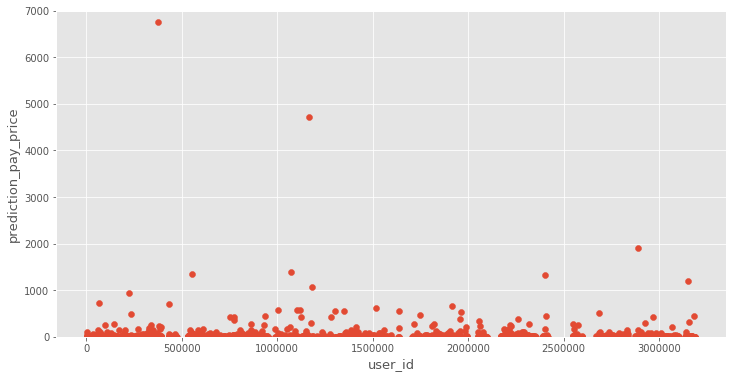

1


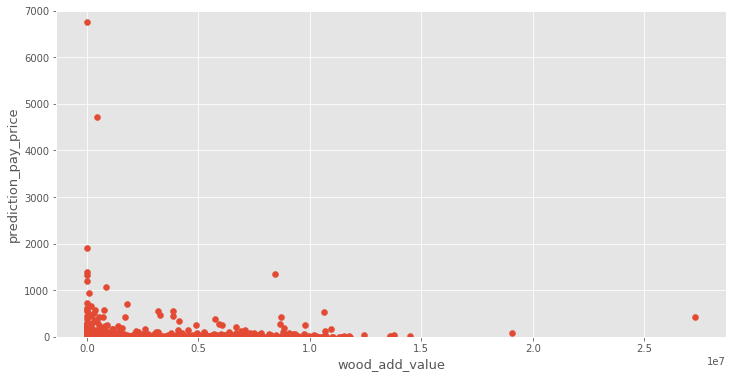

2


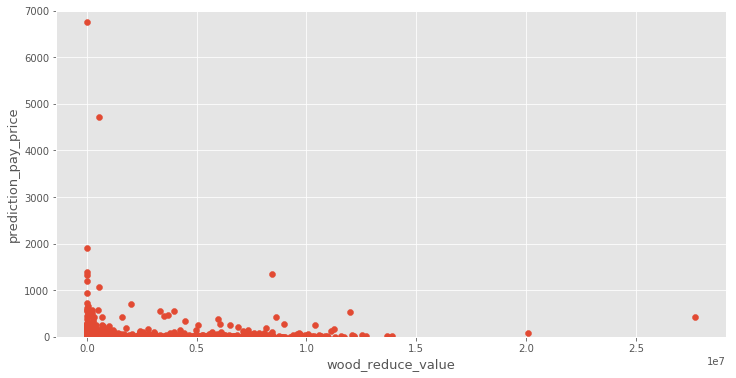

3


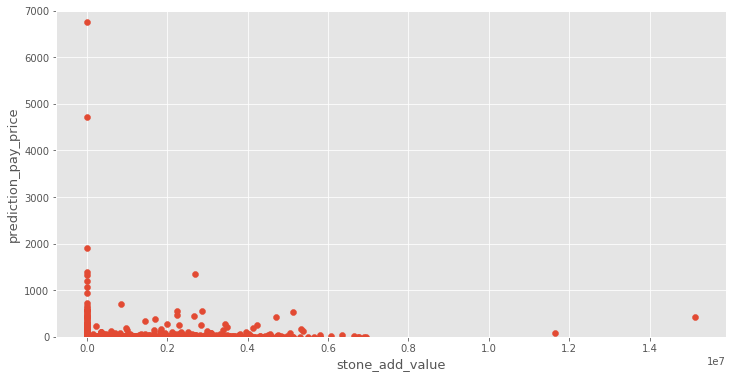

4


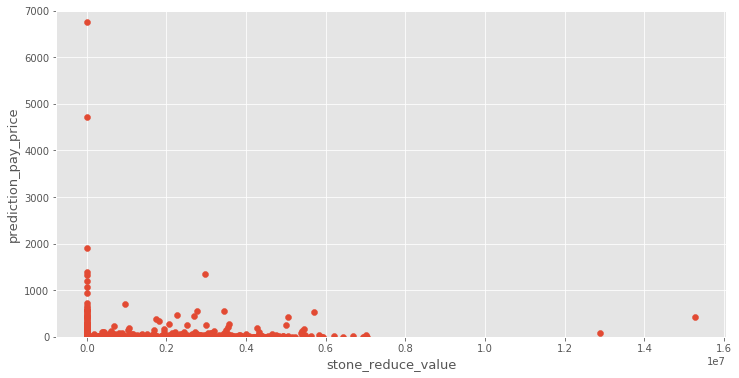

5


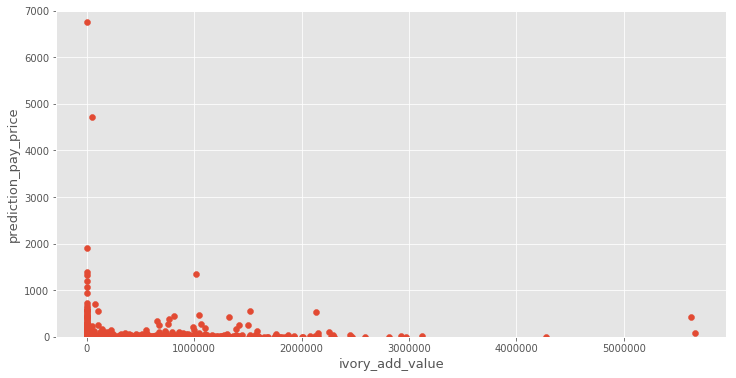

6


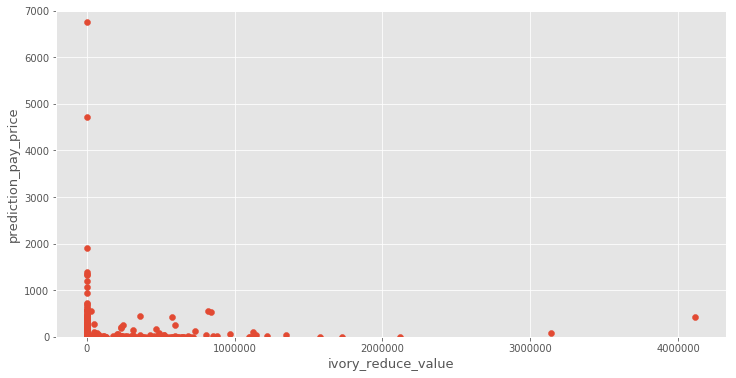

7


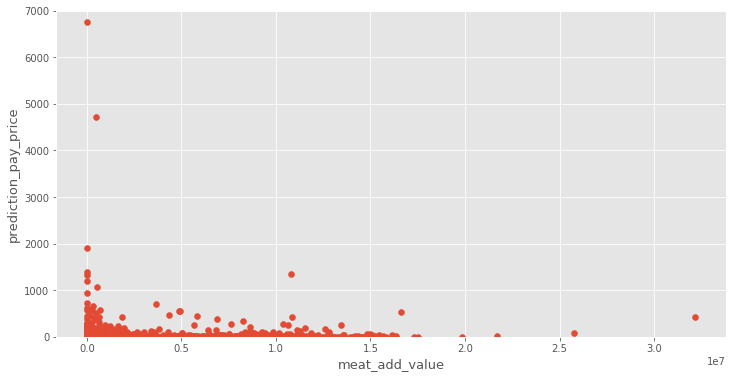

8


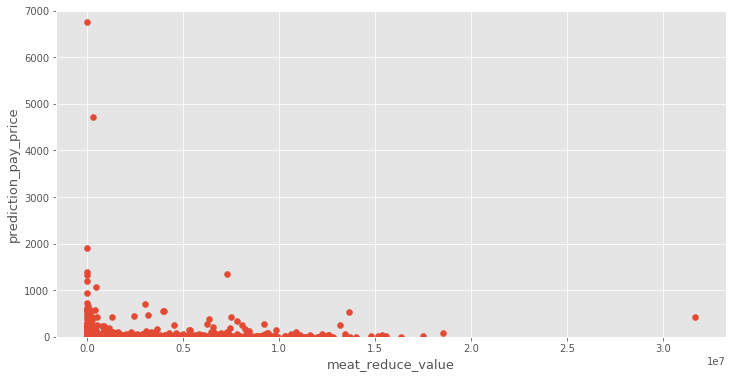

9


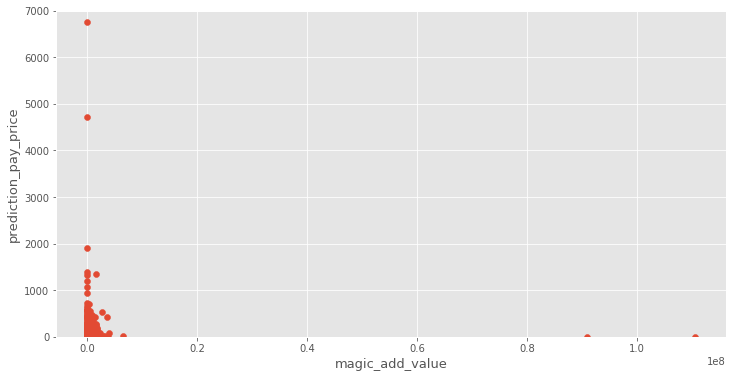

10


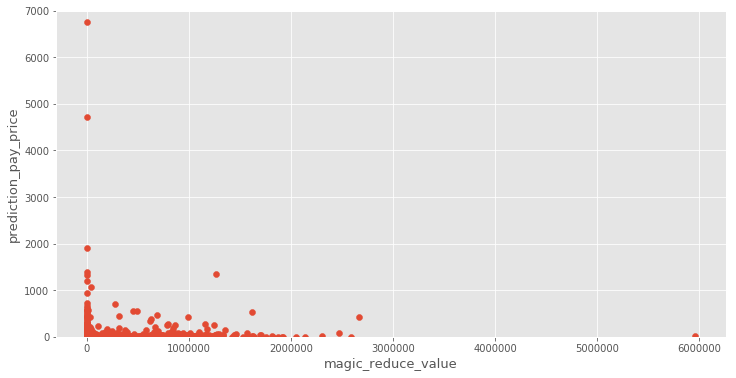

11


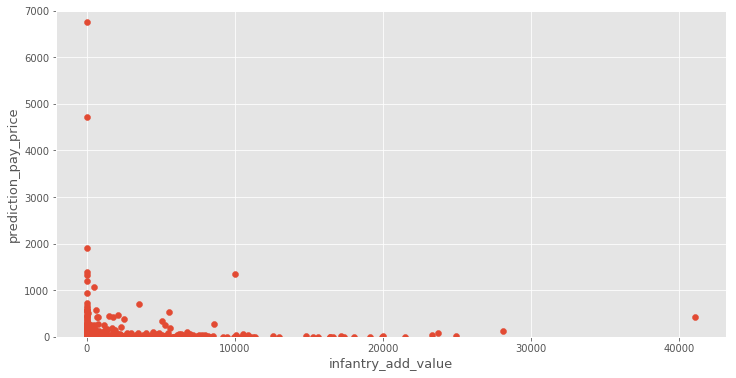

12


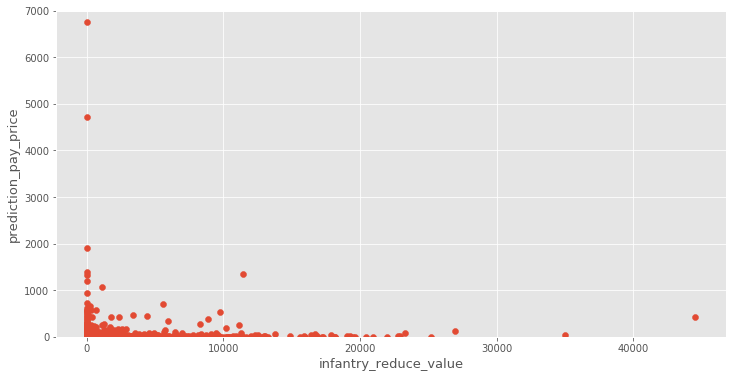

13


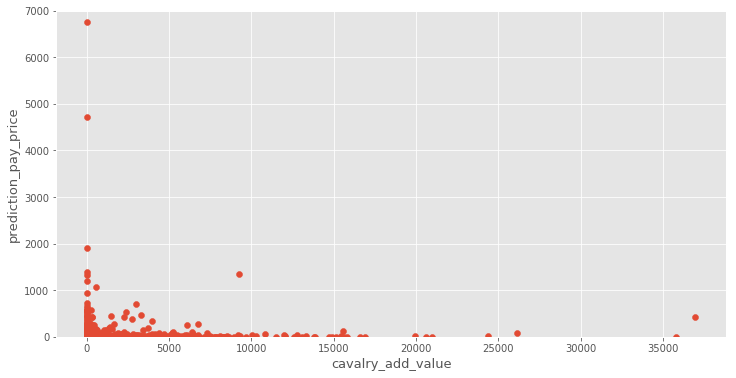

14


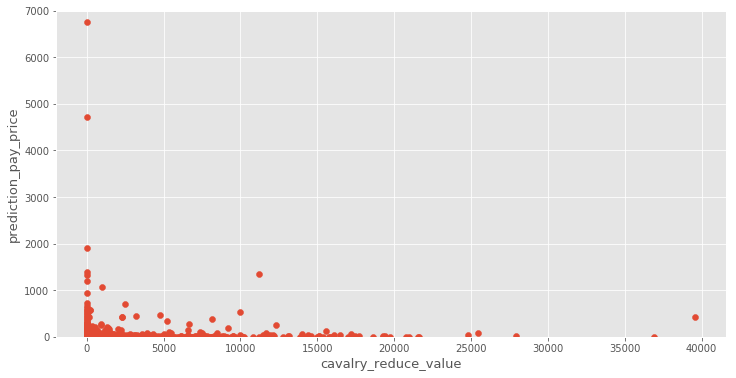

15


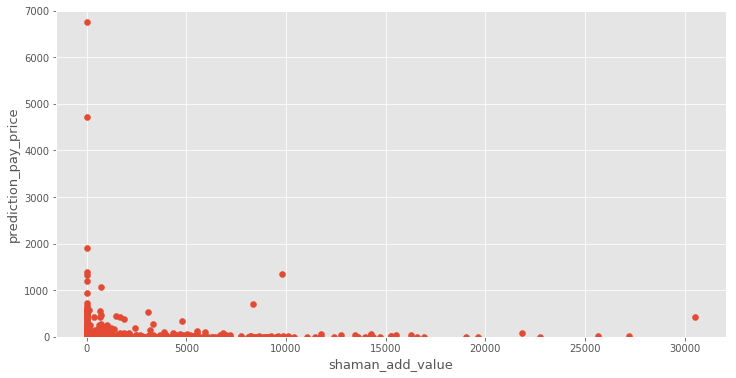

16


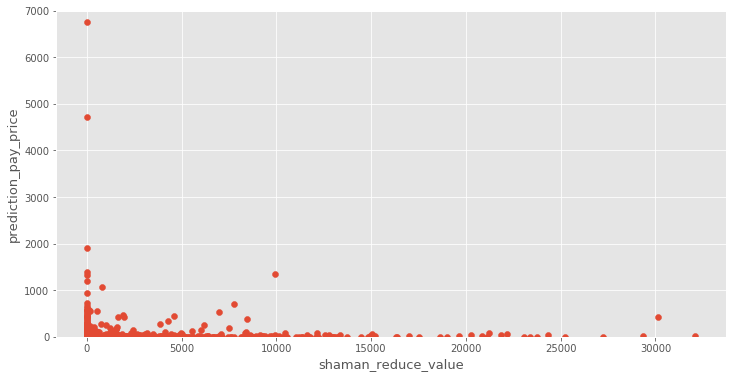

17


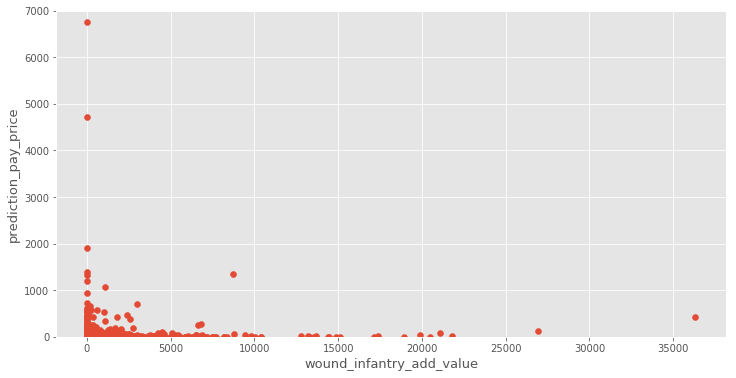

18


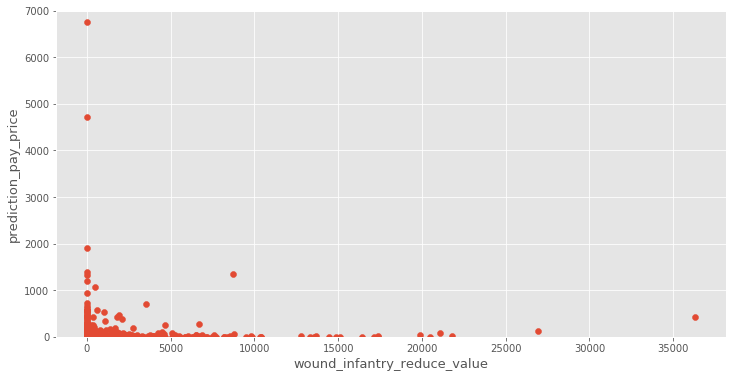

19


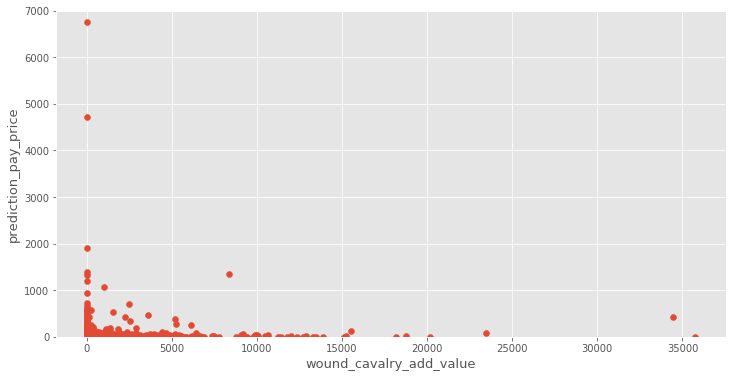

20


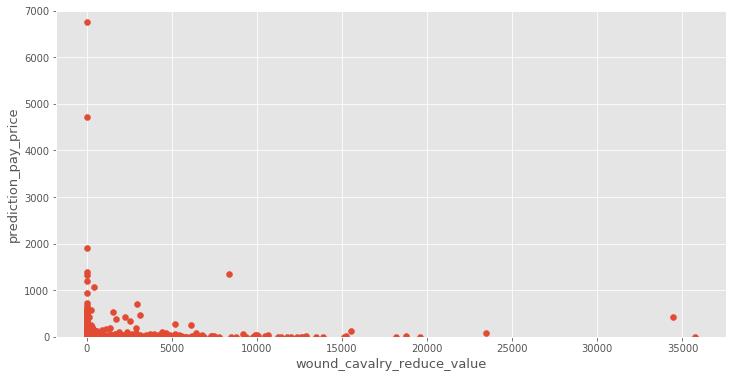

21


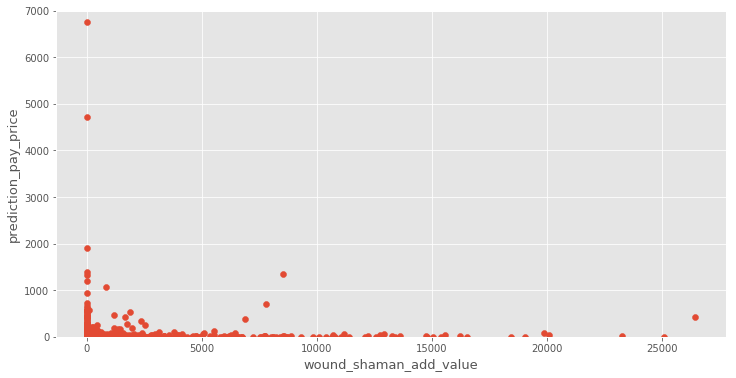

22


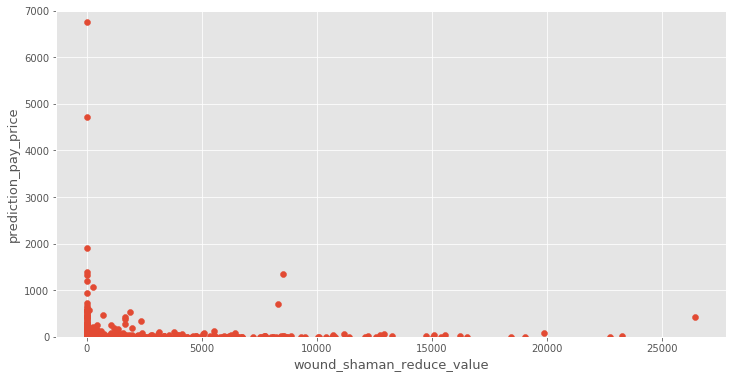

23


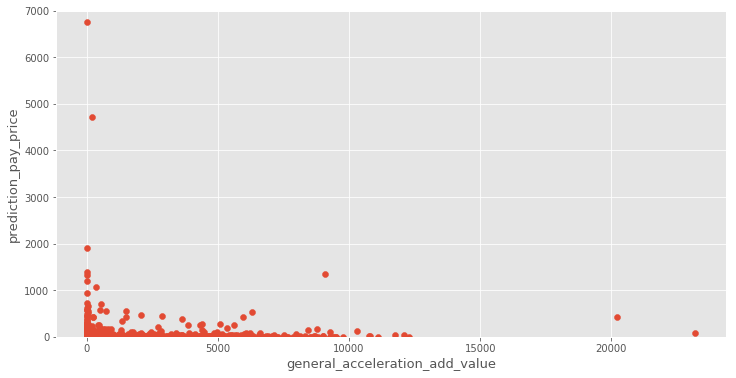

24


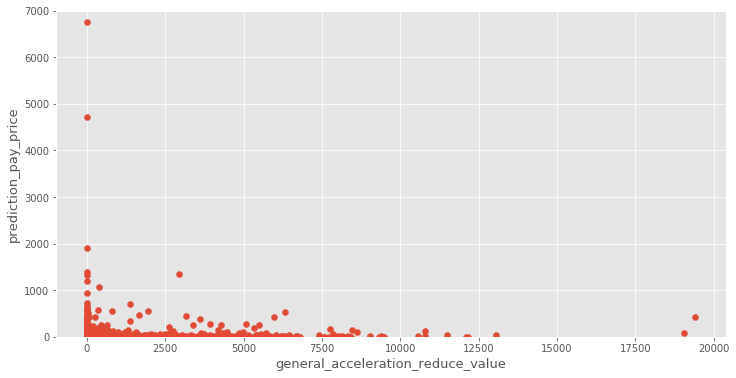

25


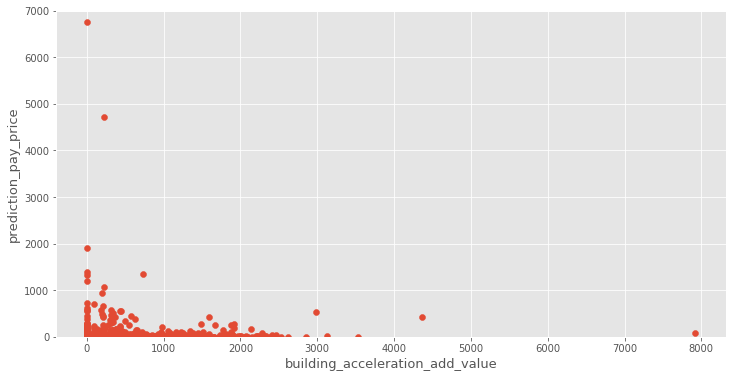

26


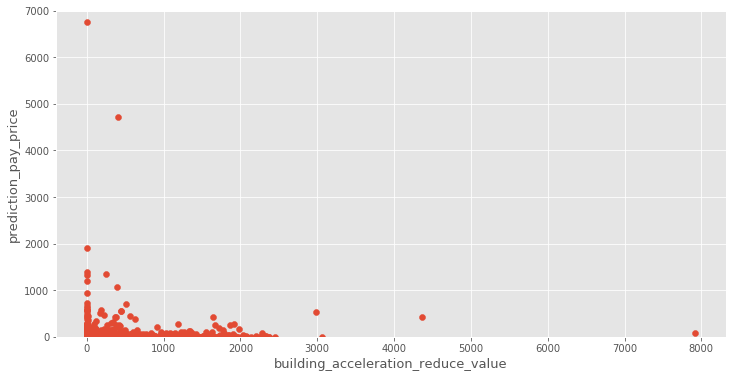

27


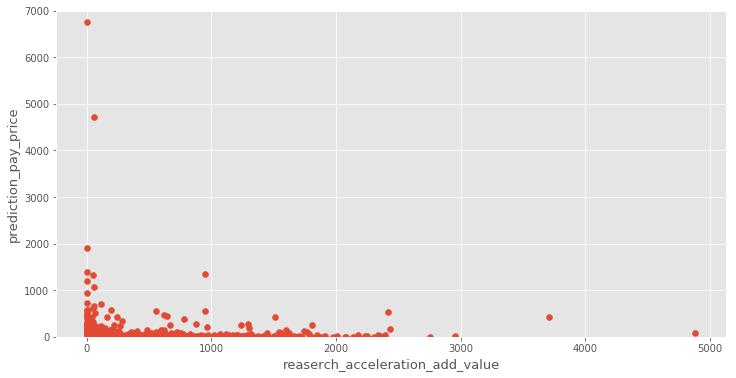

28


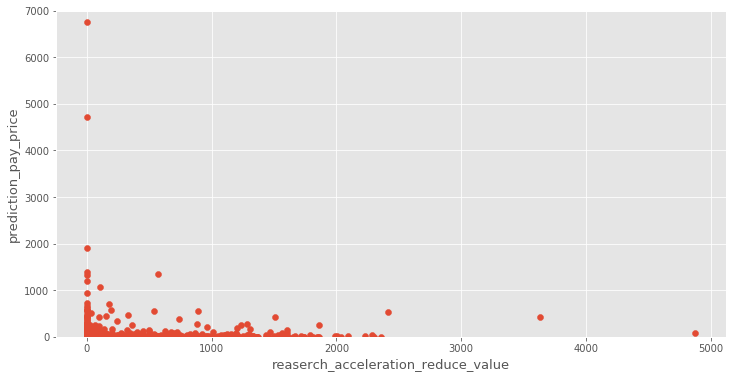

29


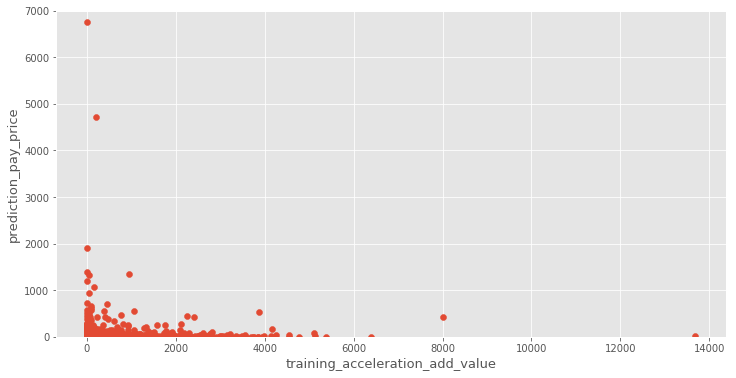

30


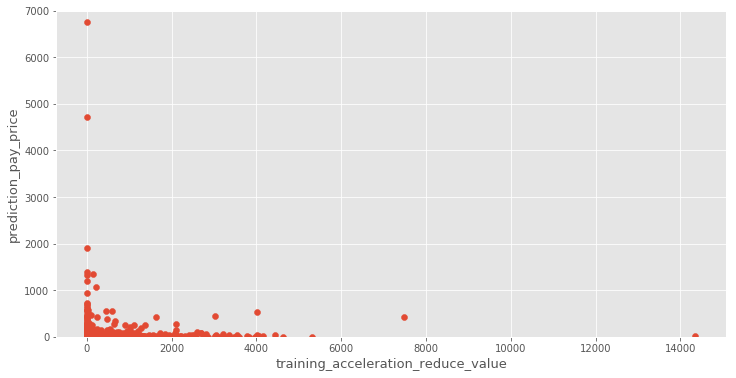

31


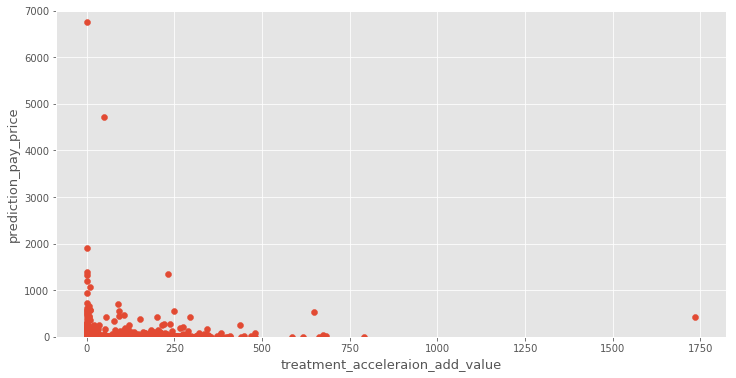

32


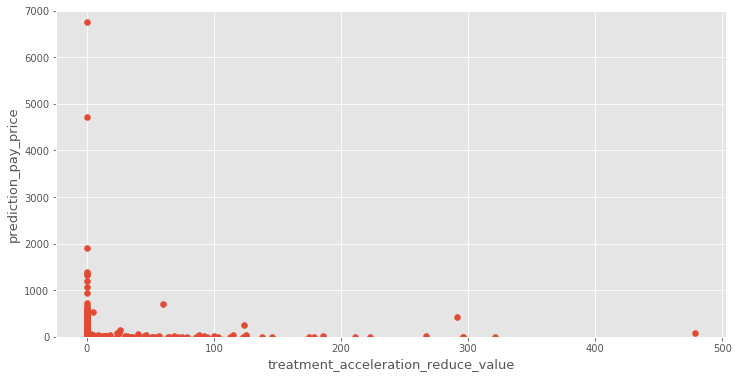

33


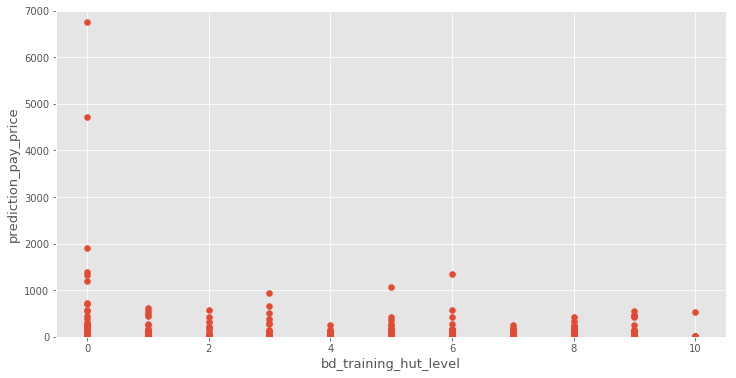

34


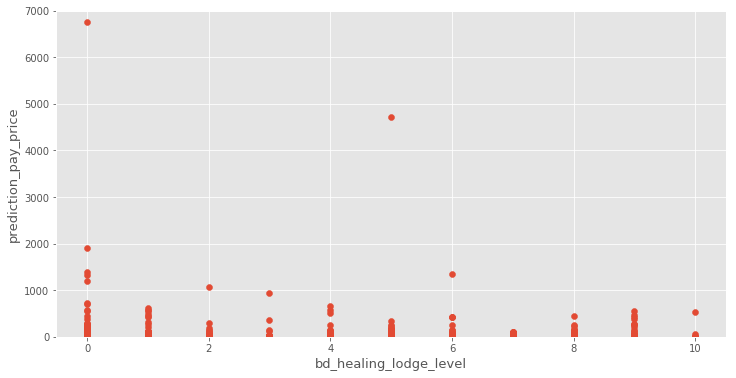

35


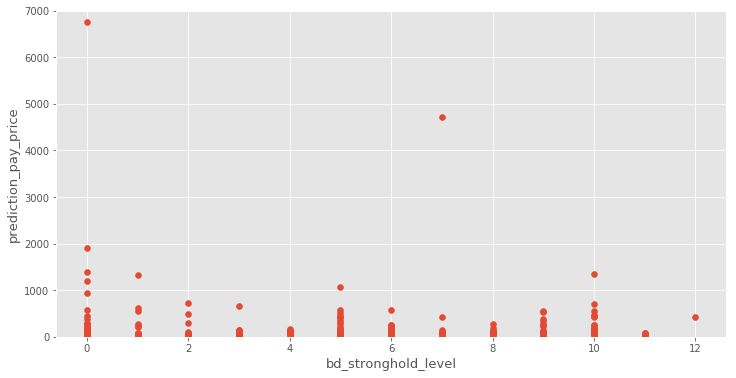

36


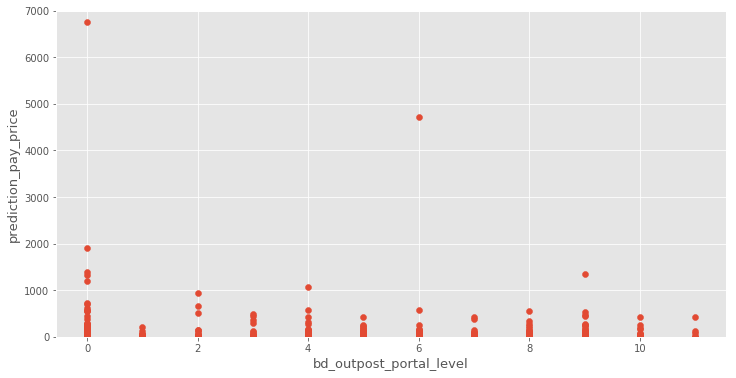

37


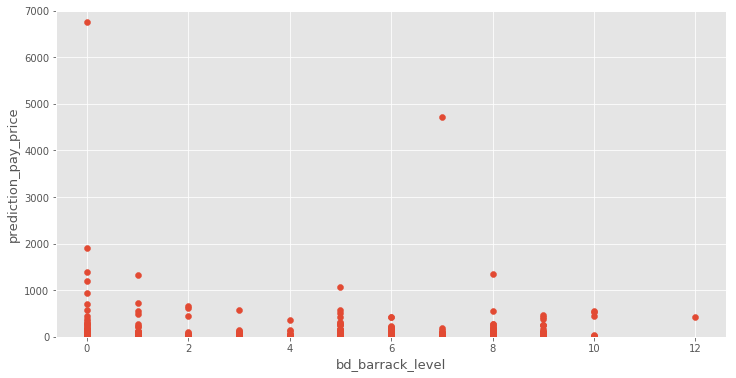

38


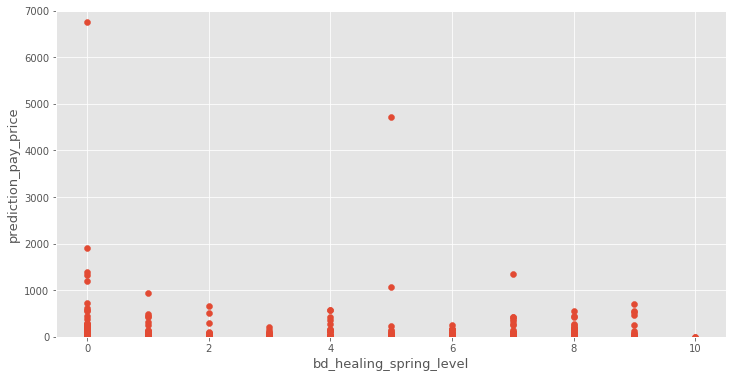

39


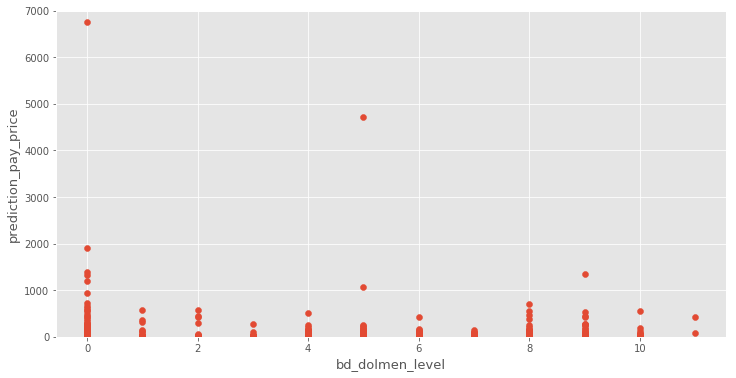

40


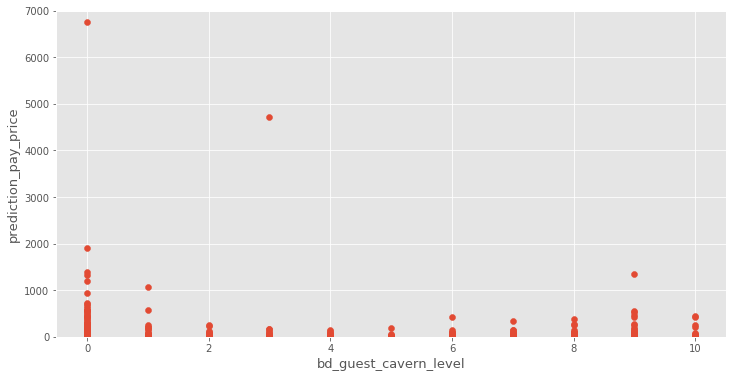

41


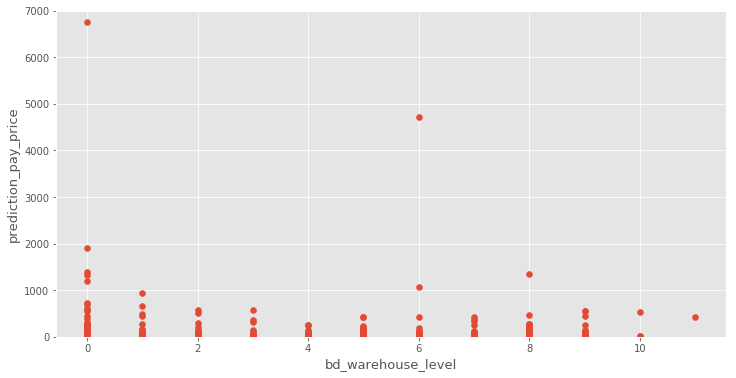

42


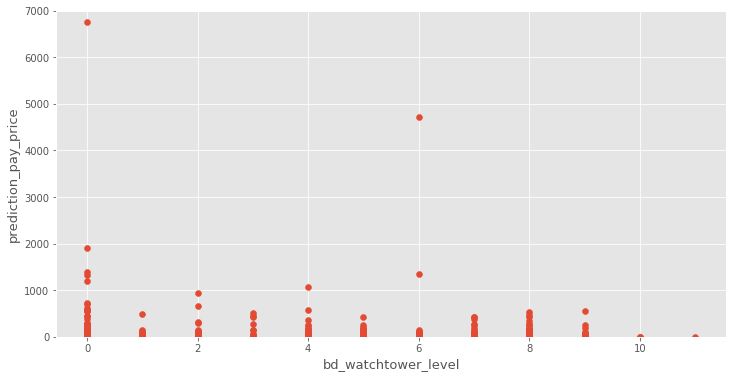

43


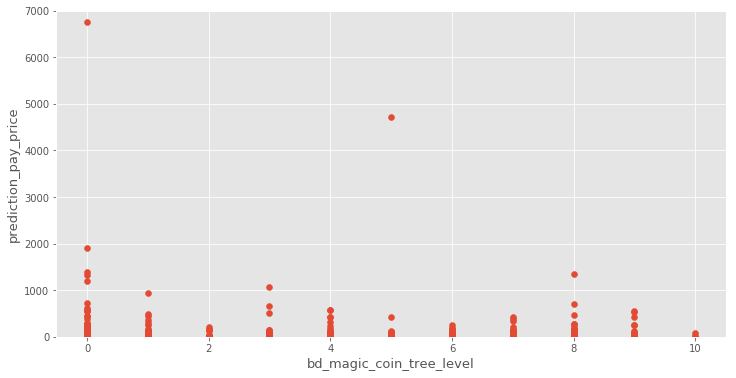

44


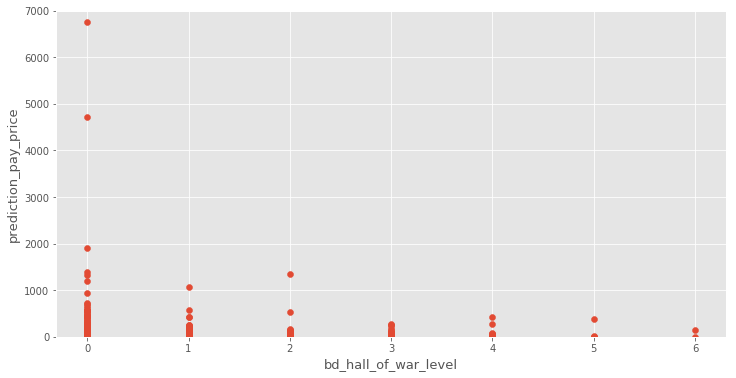

45


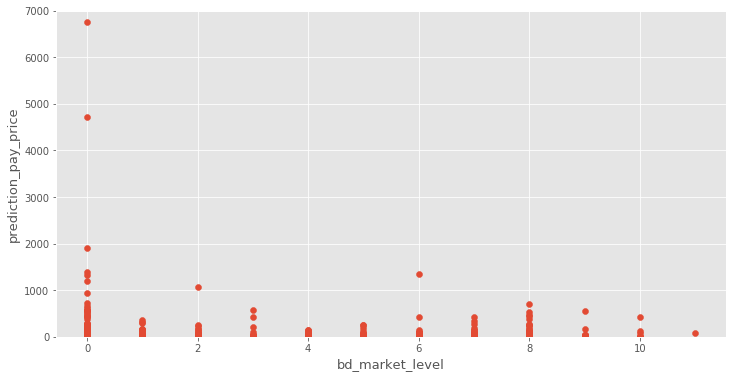

46


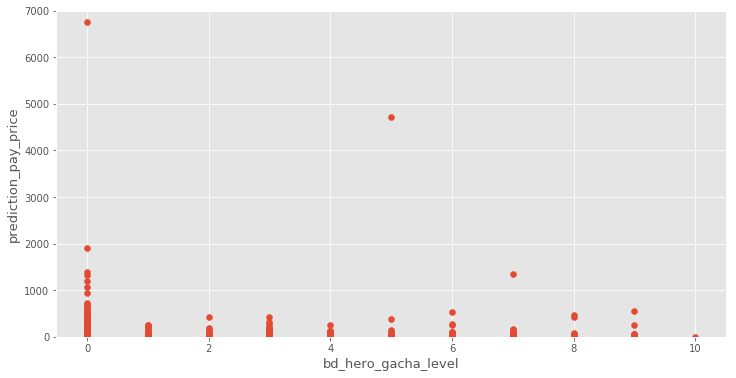

47


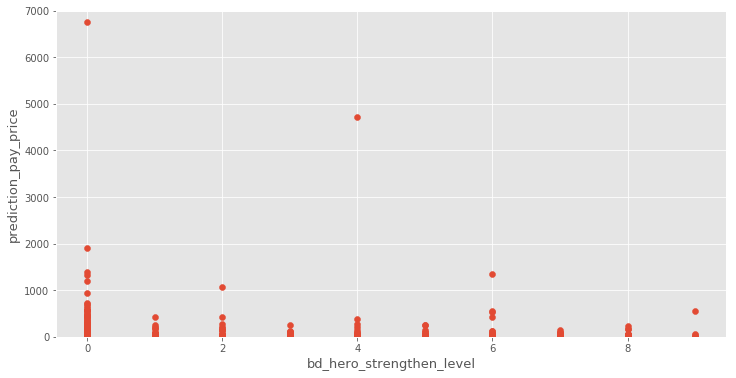

48


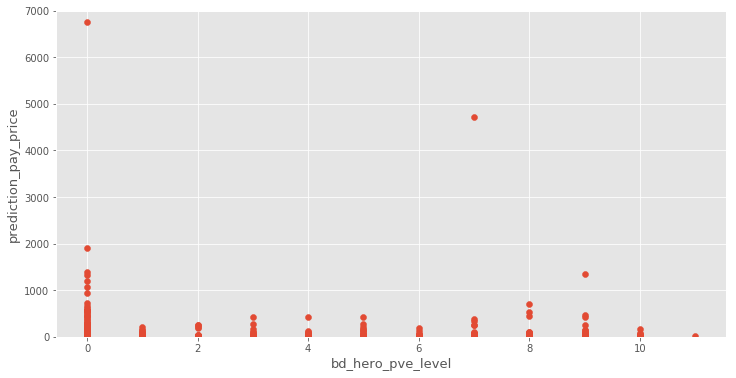

49


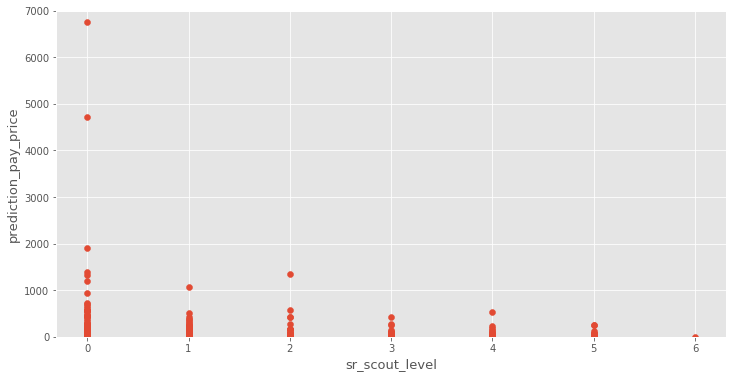

50


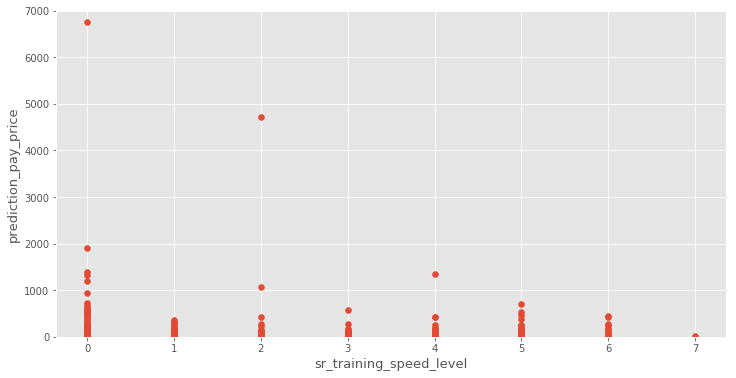

51


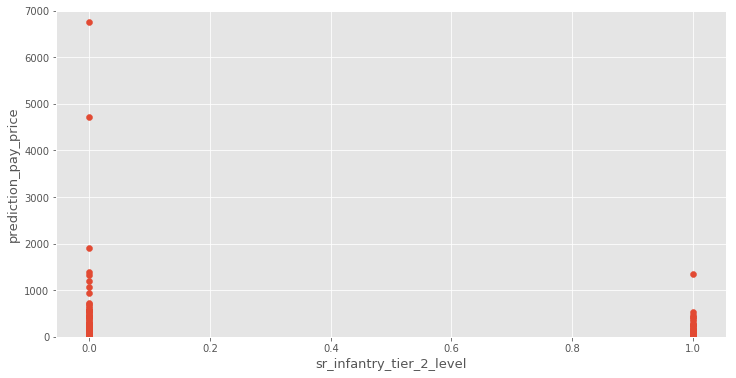

52


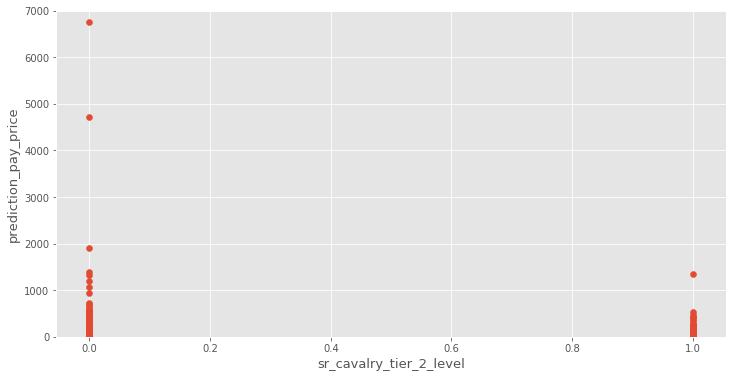

53


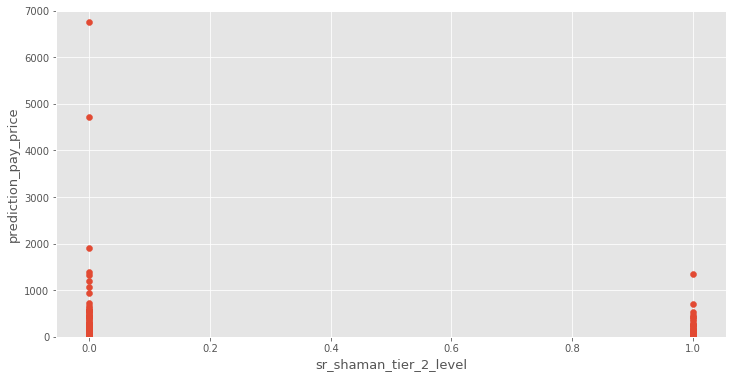

54


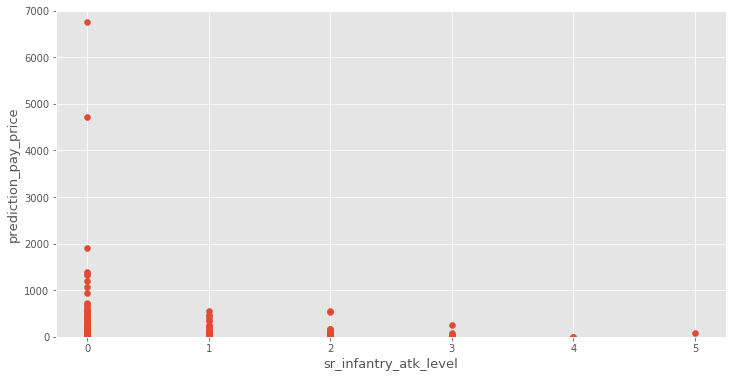

55


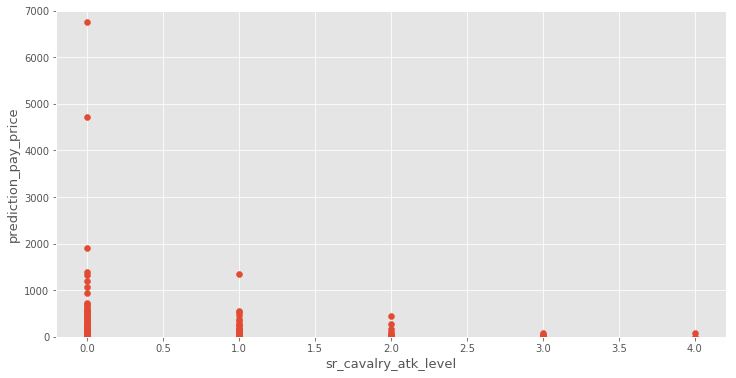

56


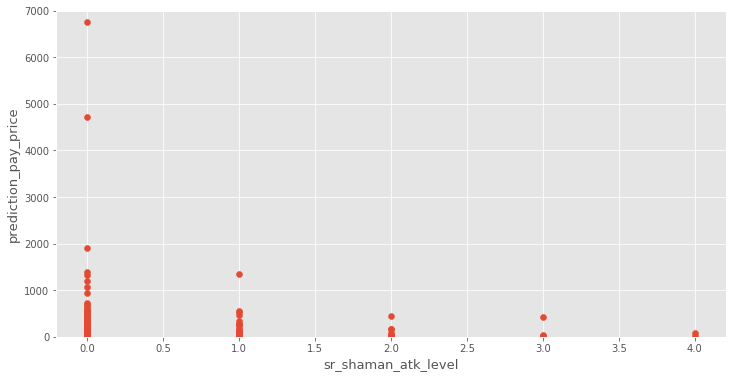

57


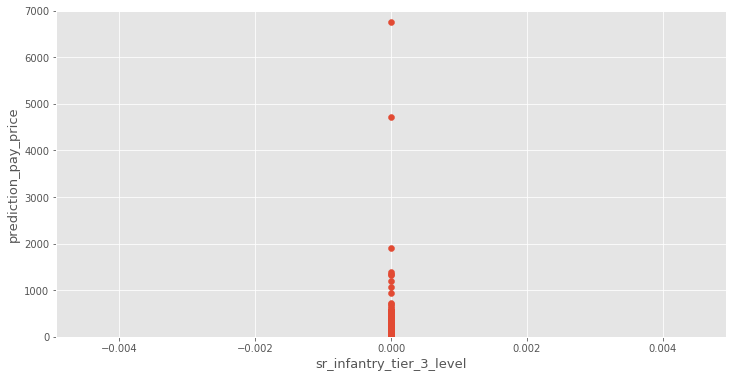

58


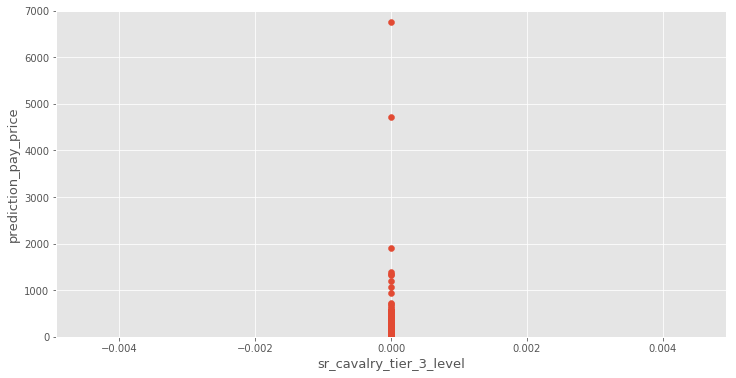

59


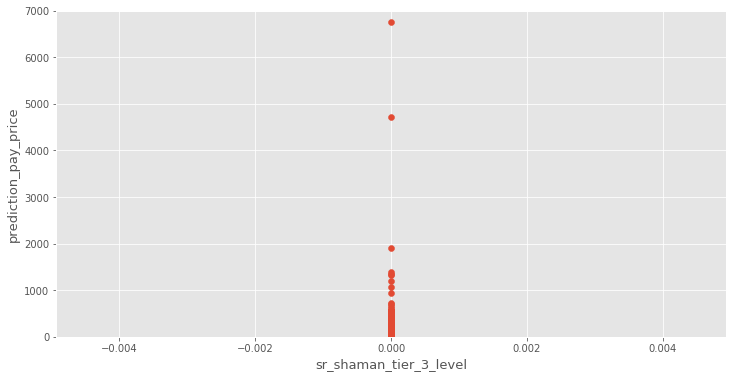

60


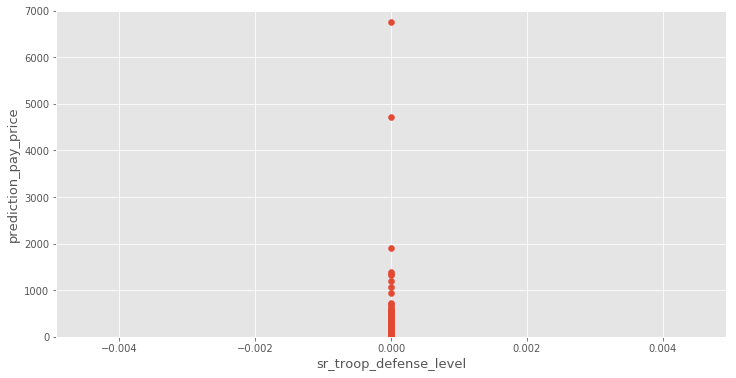

61


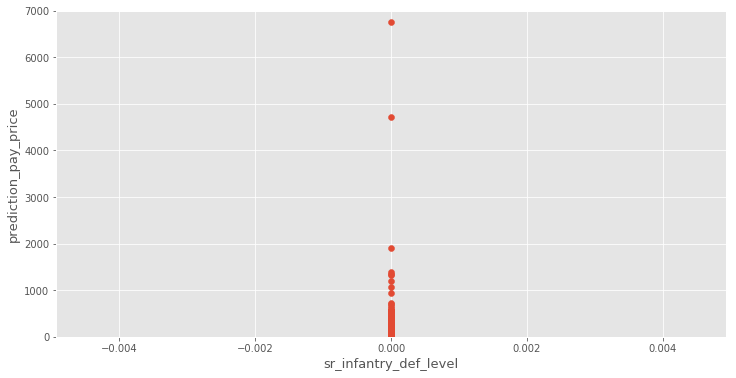

62


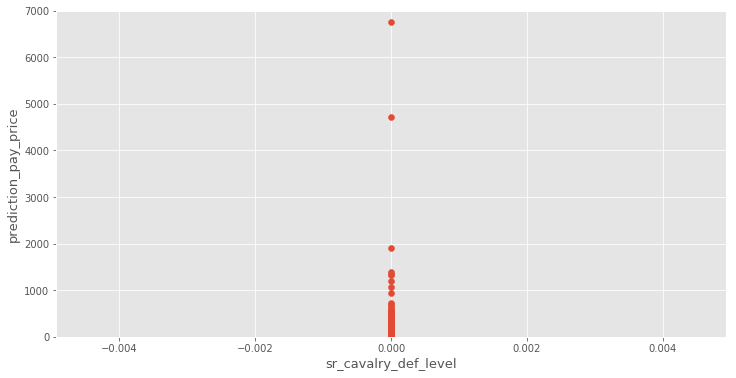

63


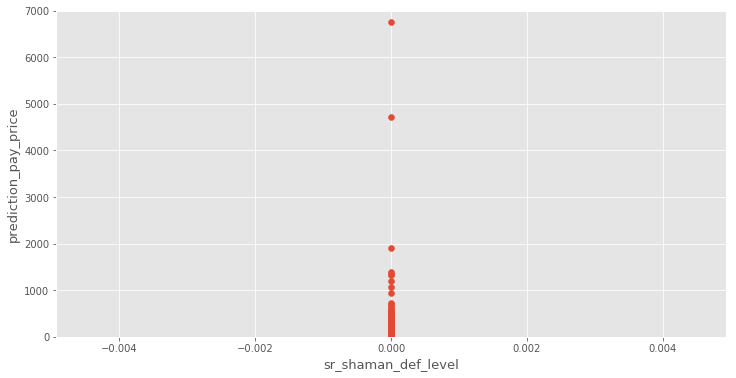

64


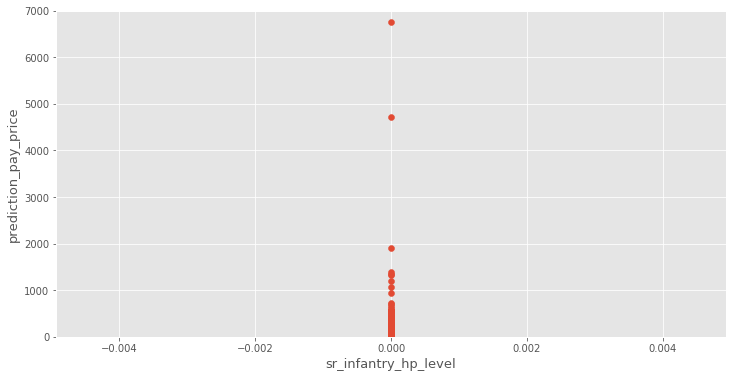

65


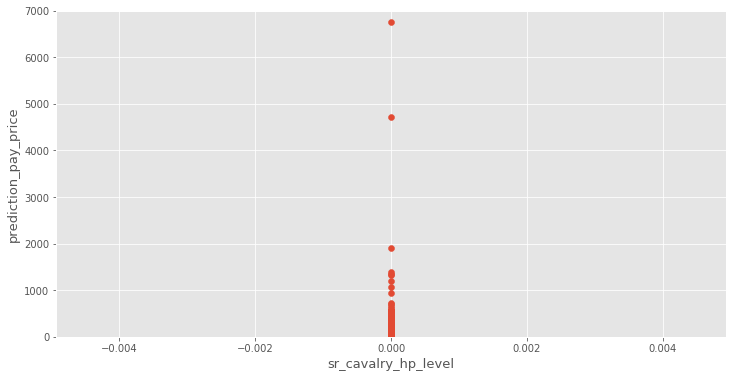

66


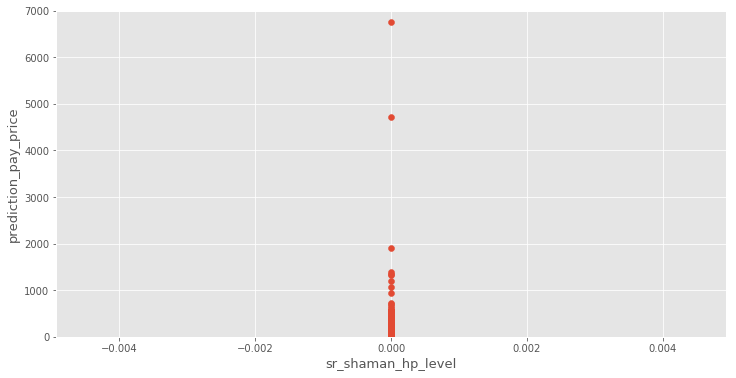

67


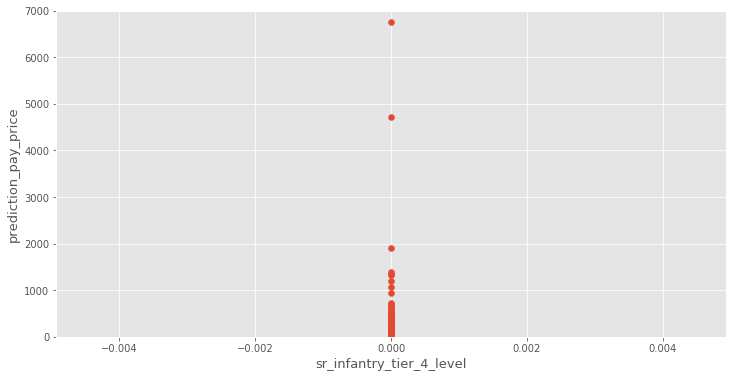

68


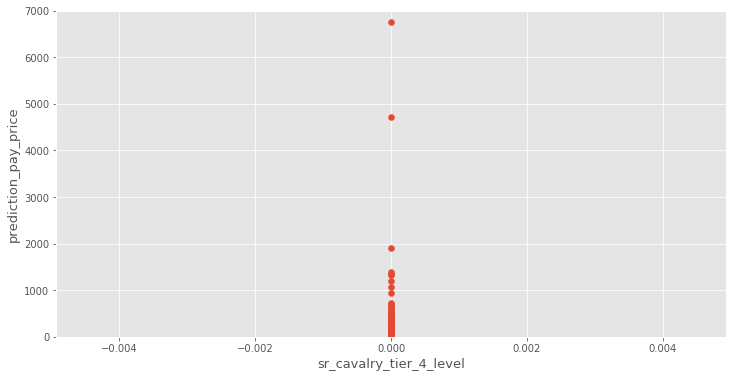

69


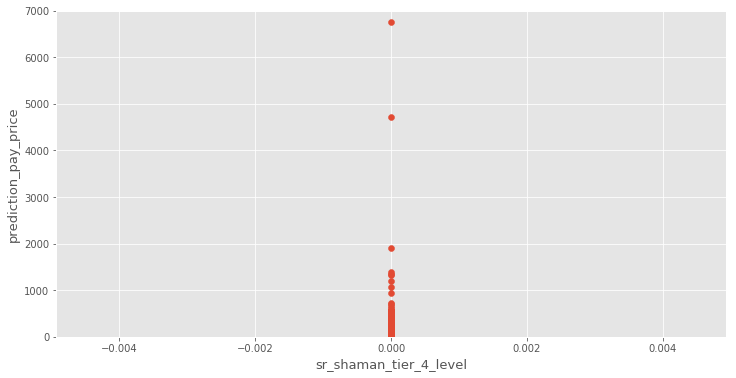

70


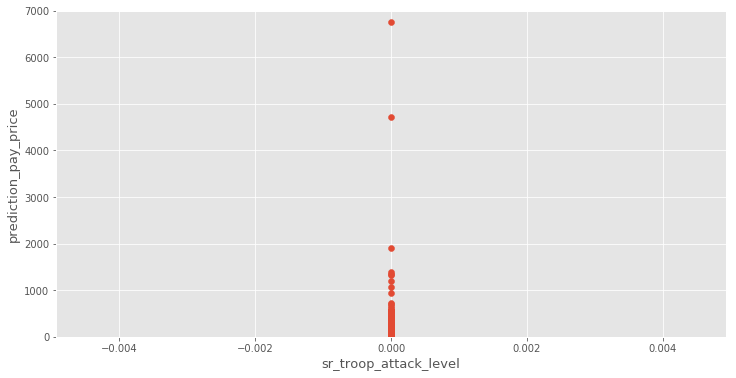

71


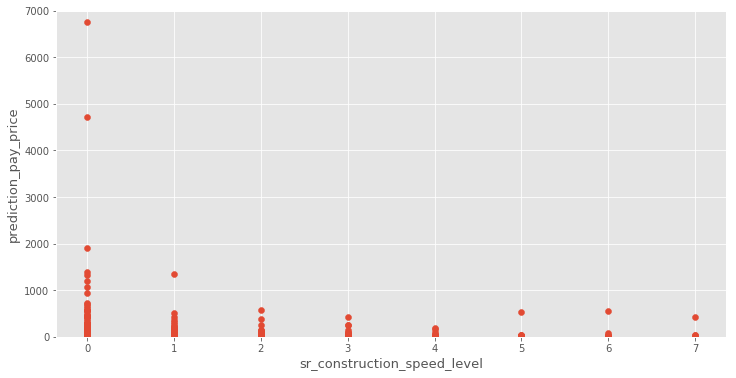

72


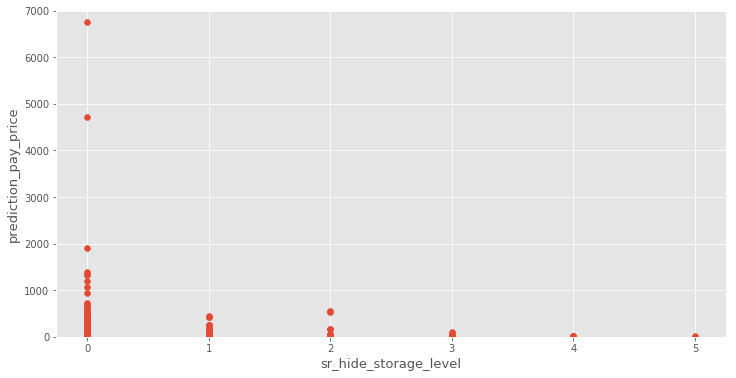

73


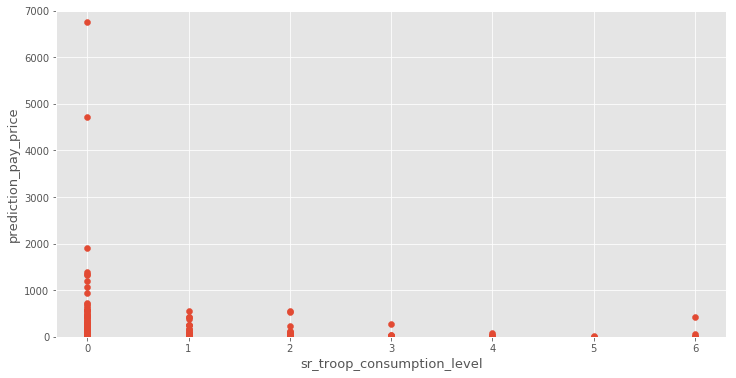

74


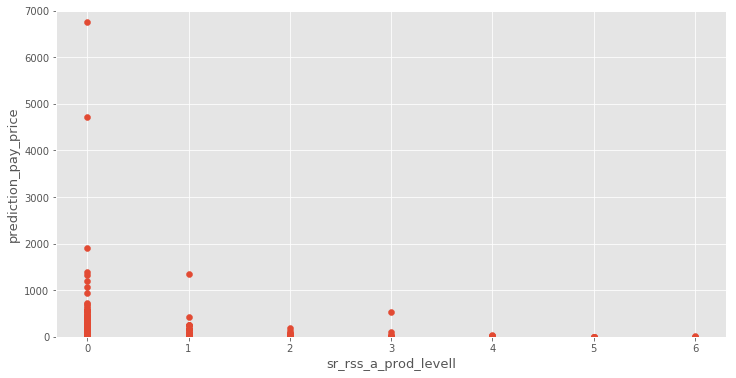

75


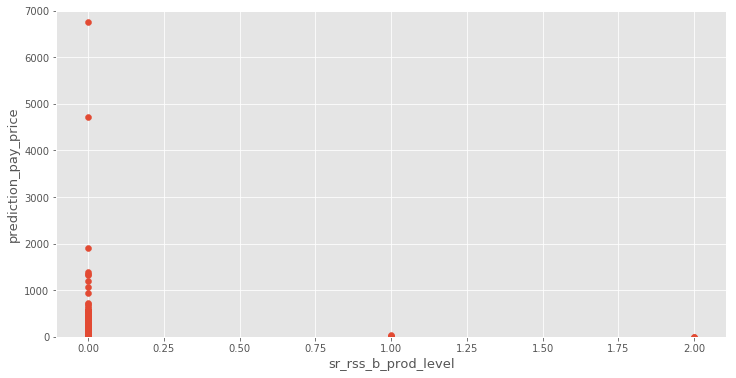

76


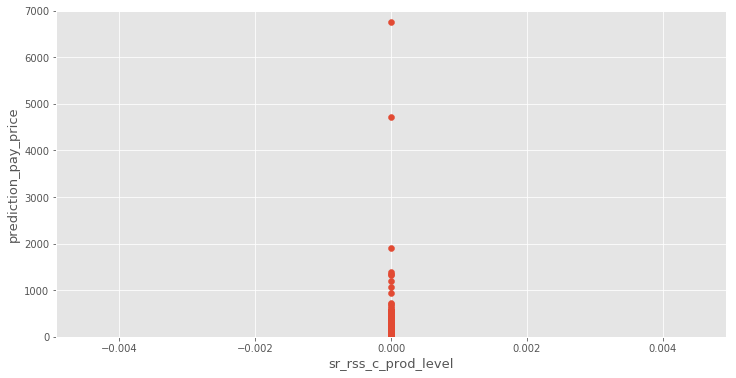

77


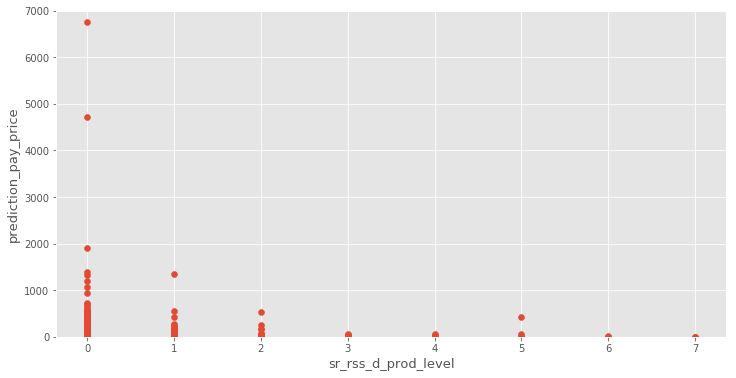

78


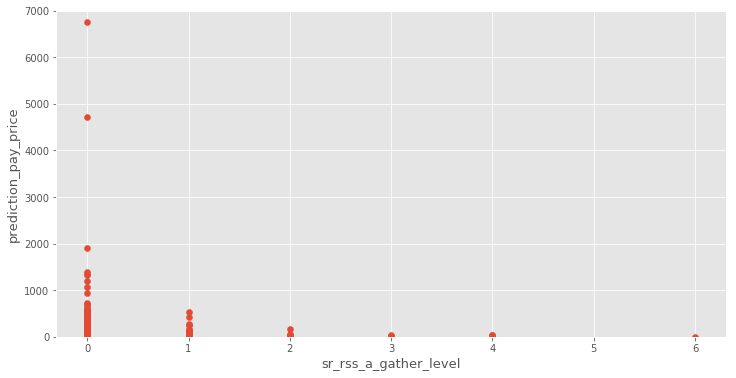

79


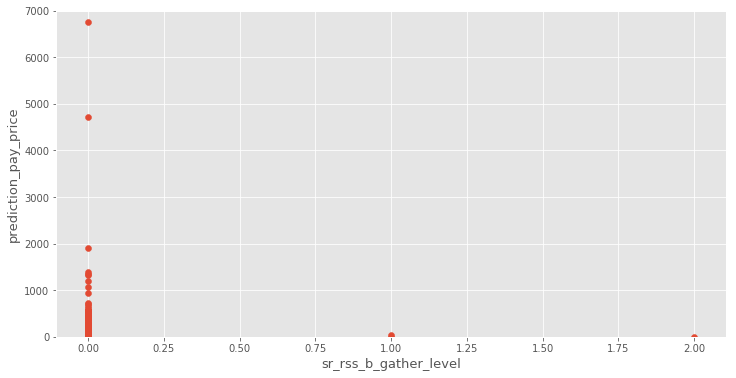

80


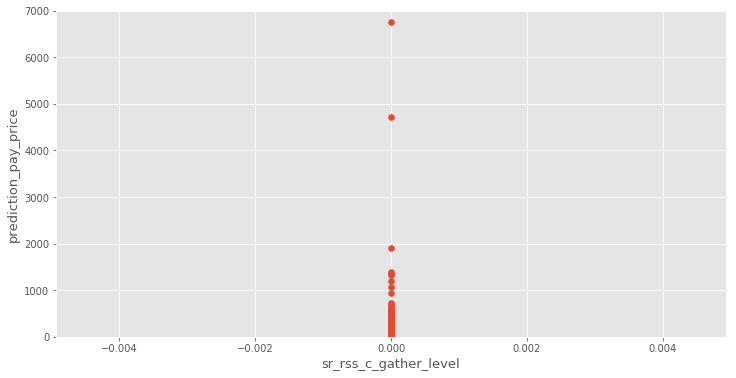

81


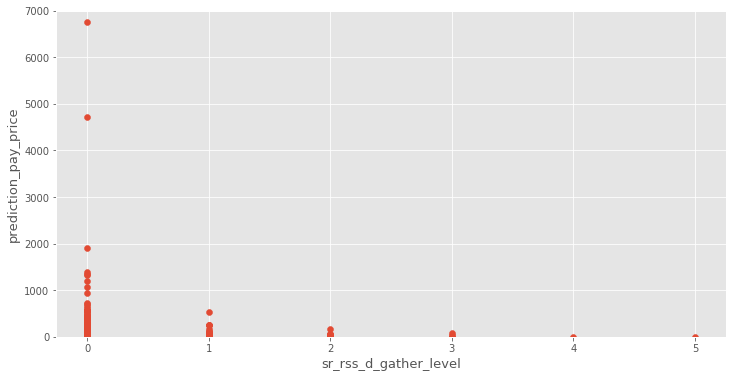

82


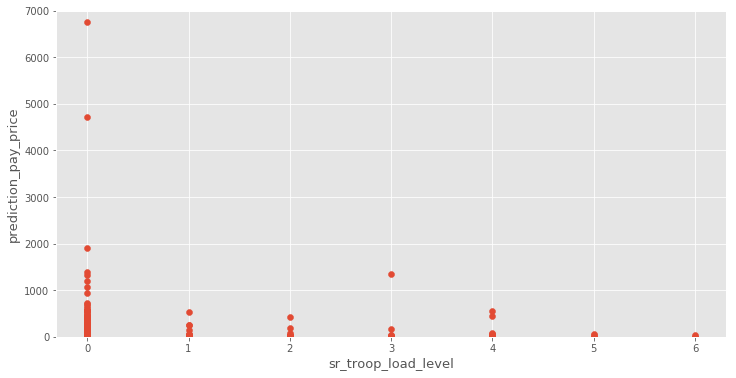

83


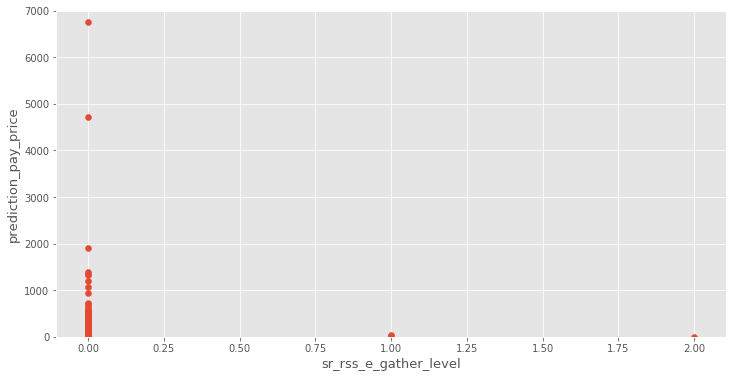

84


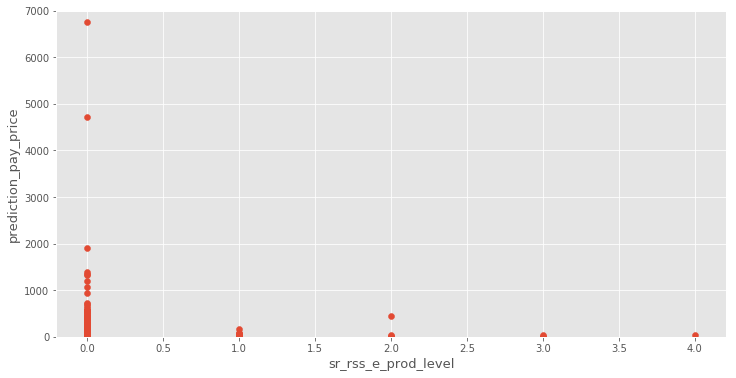

85


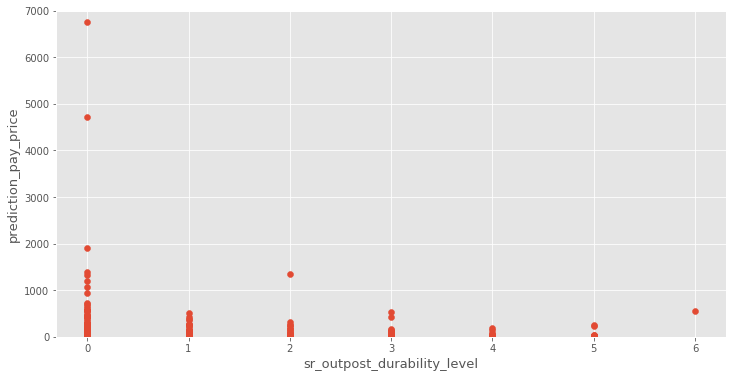

86


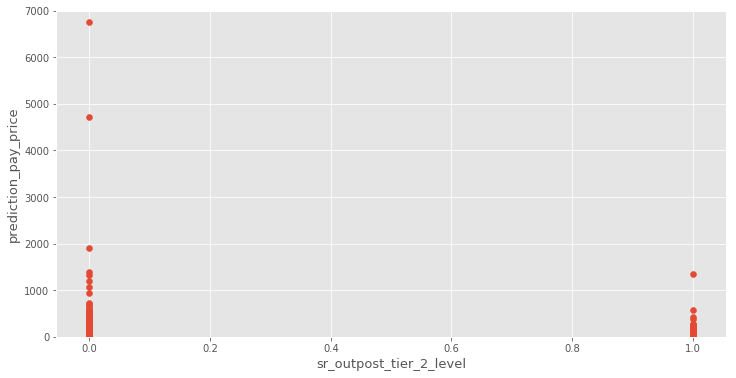

87


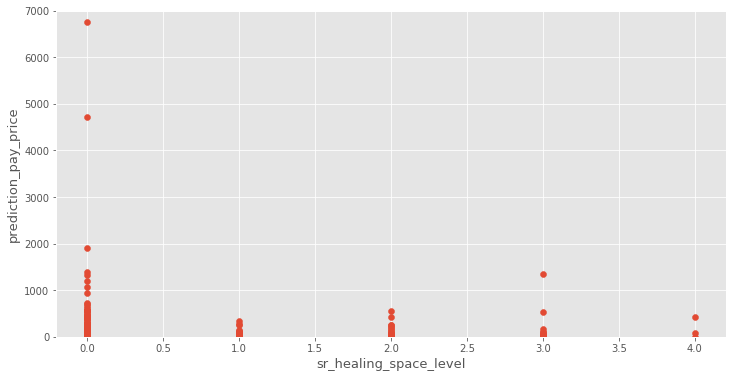

88


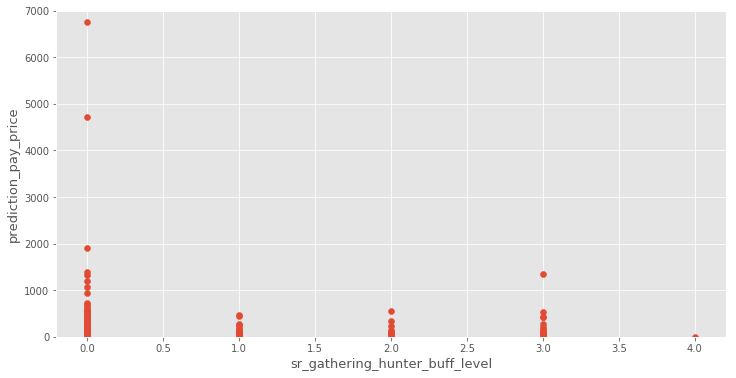

89


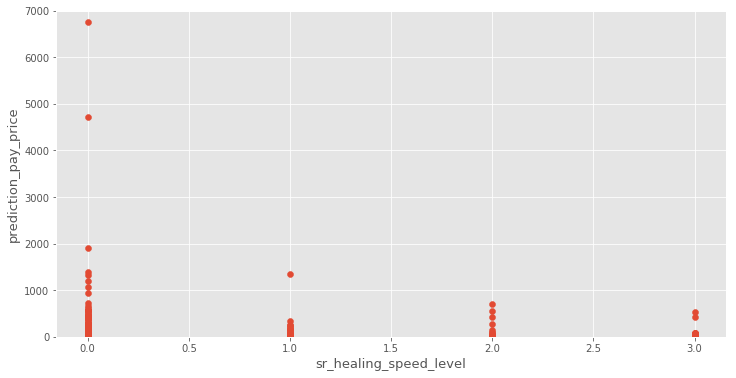

90


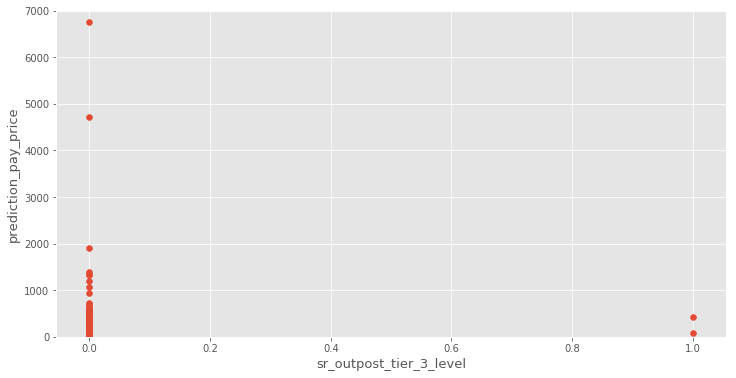

91


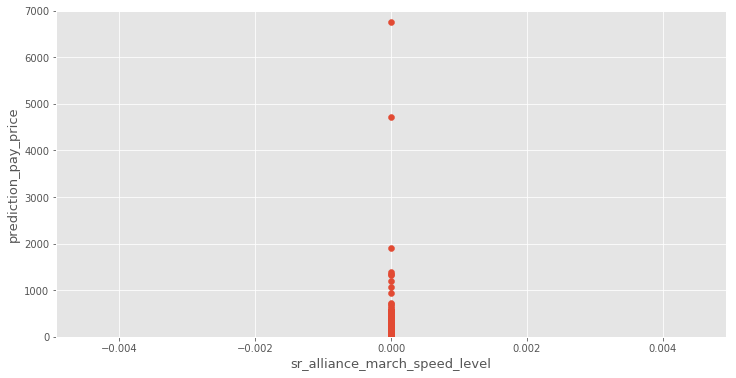

92


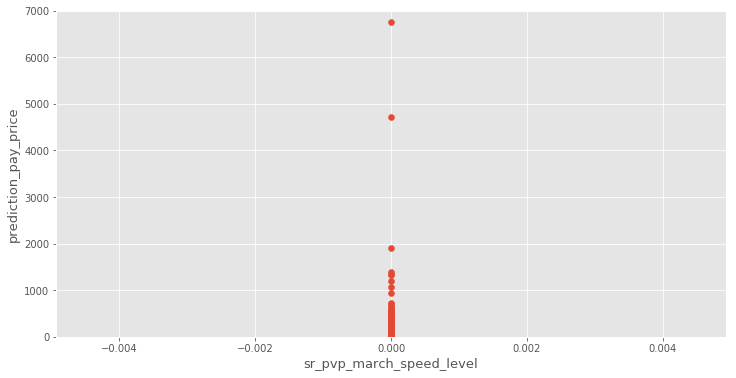

93


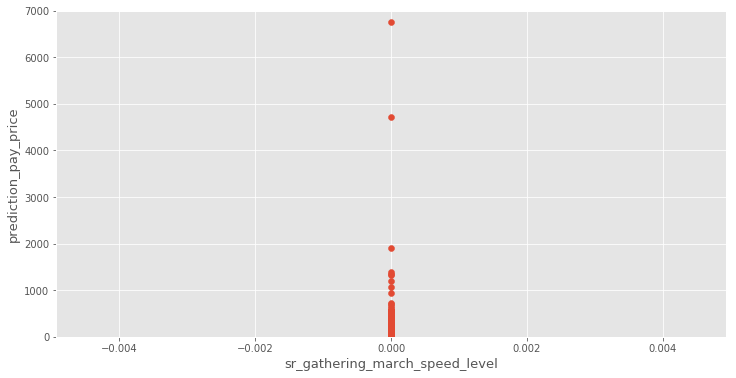

94


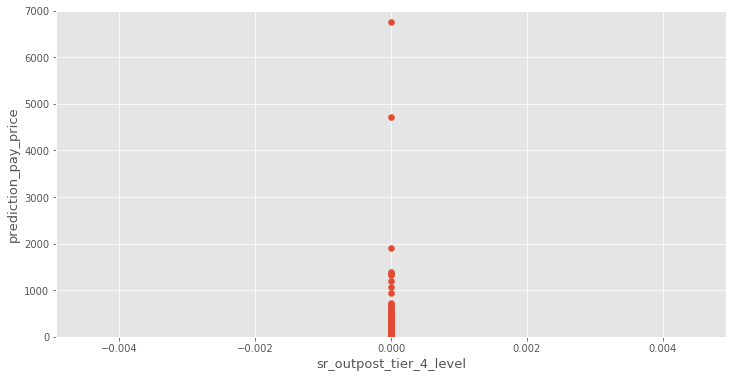

95


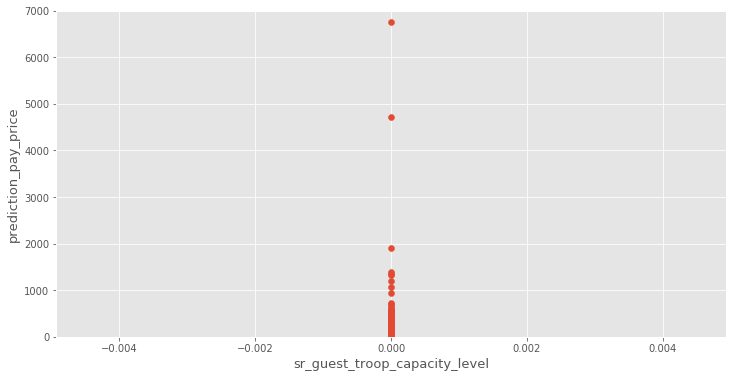

96


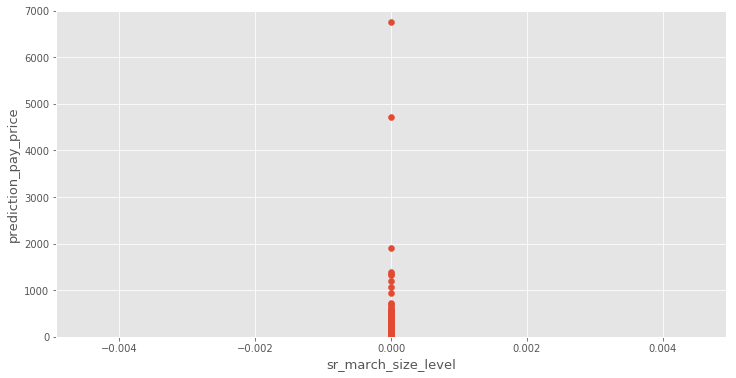

97


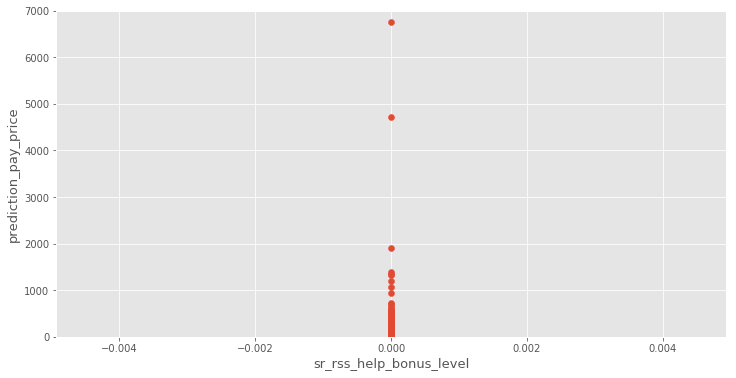

98


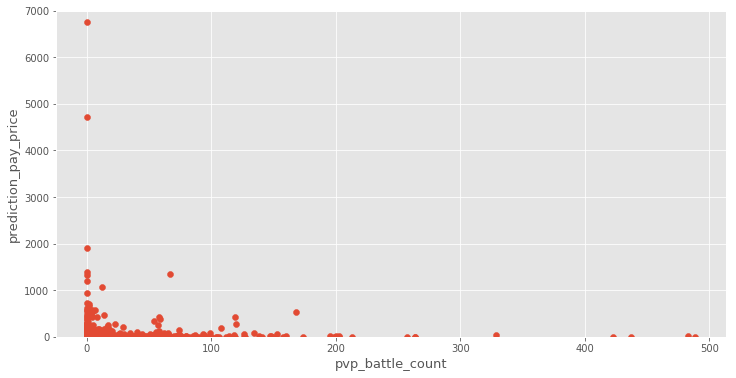

99


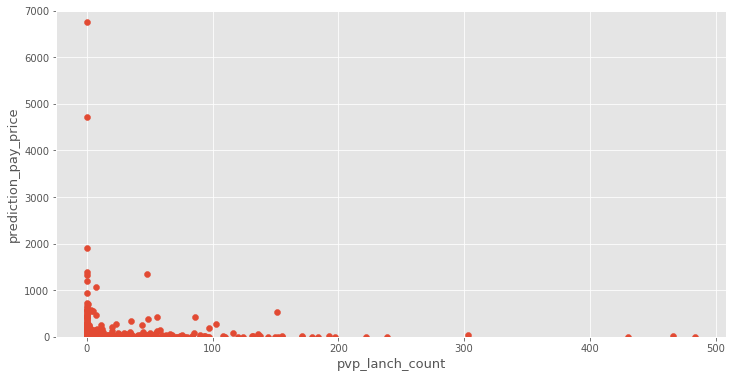

100


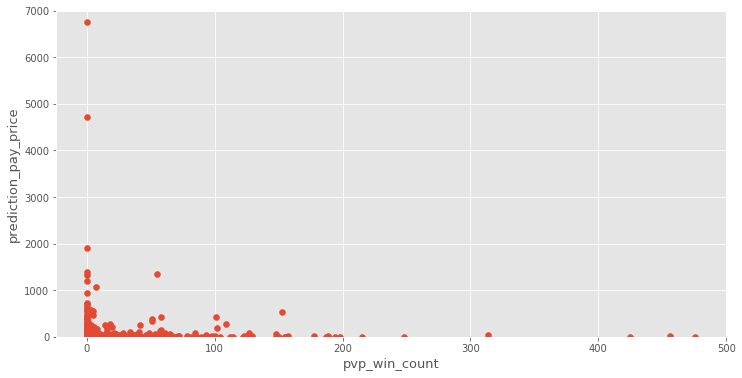

101


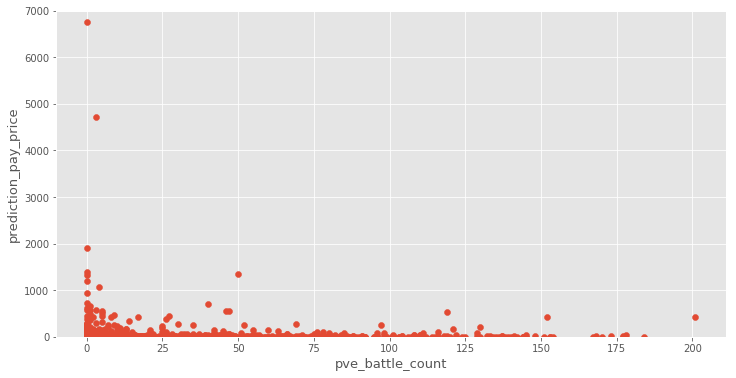

102


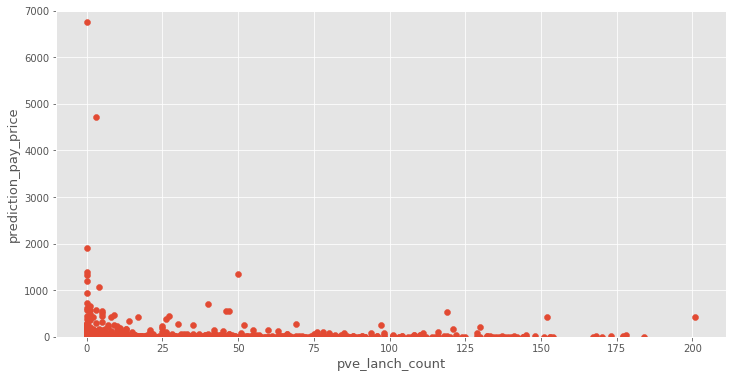

103


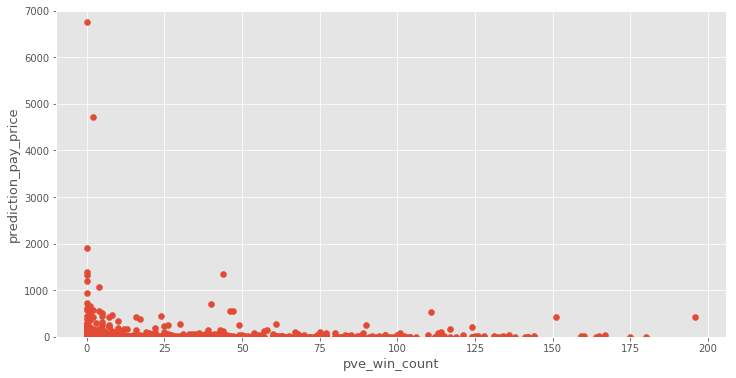

104


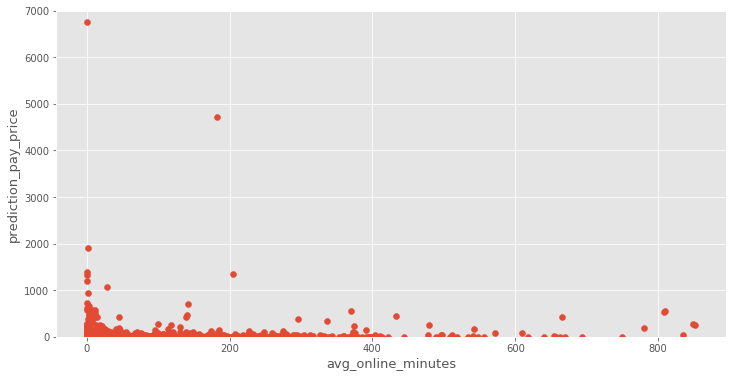

105


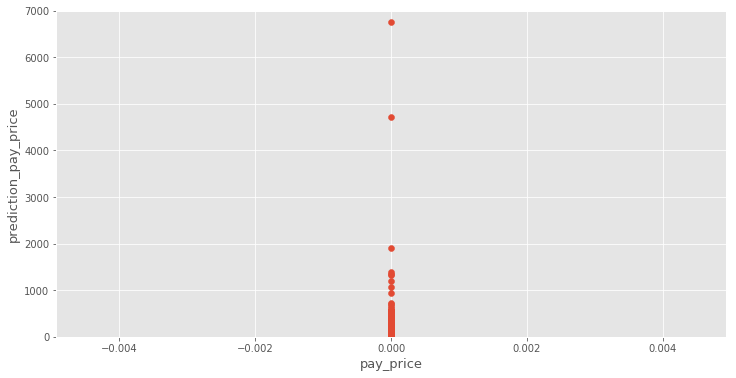

106


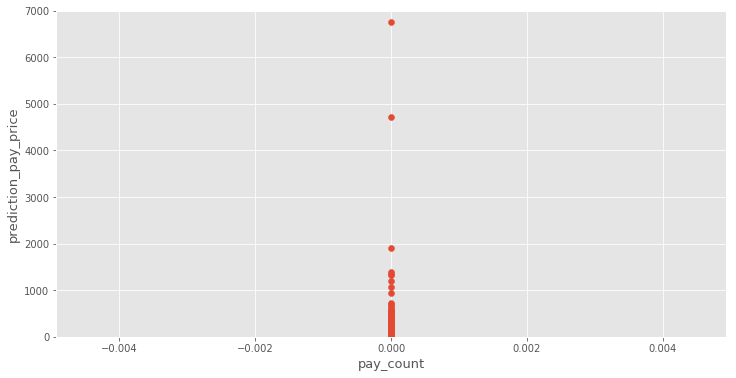

107


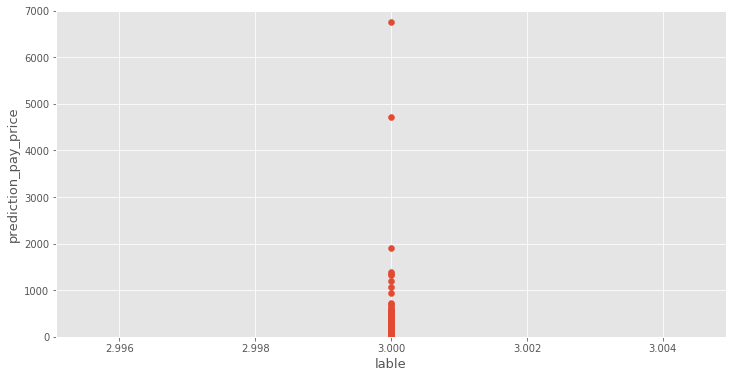

108


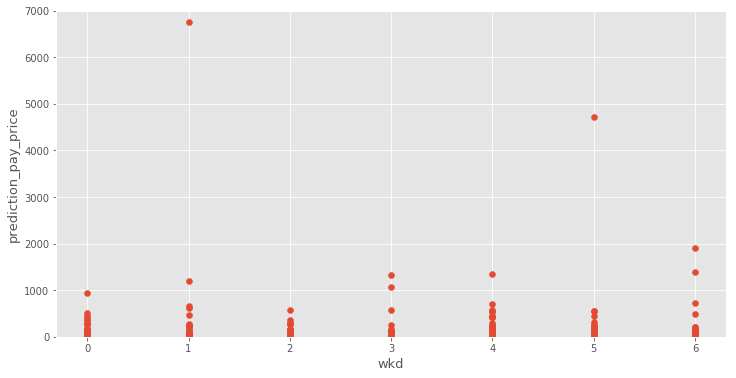

109


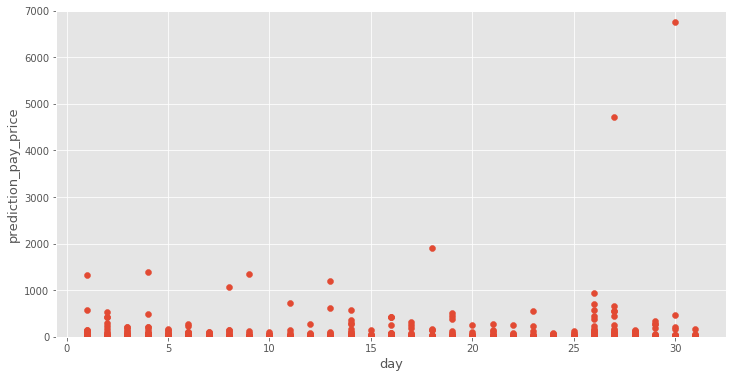

110


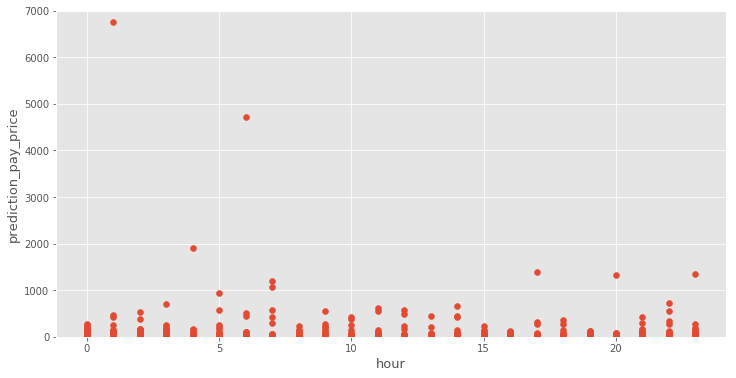

111


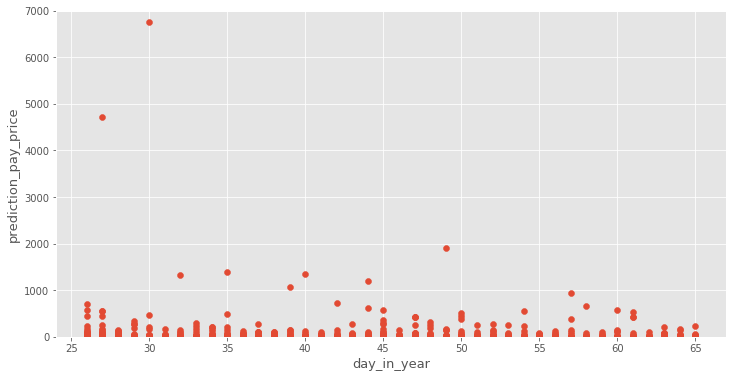

112


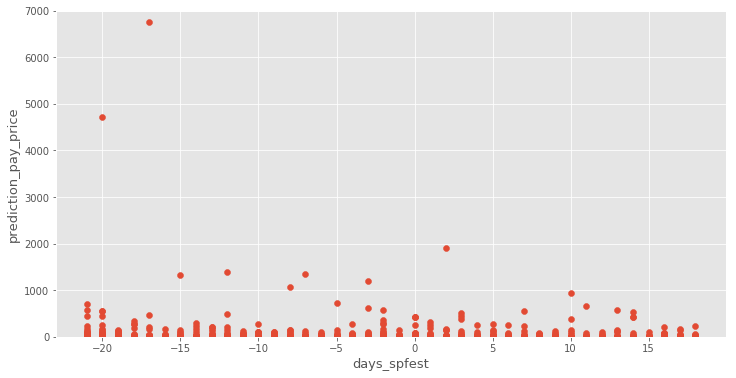

113


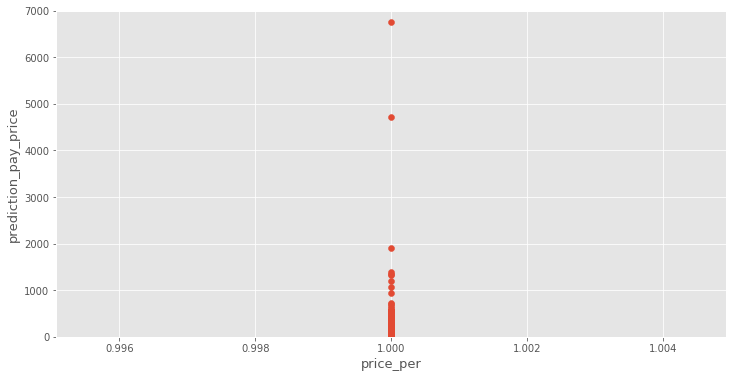

114


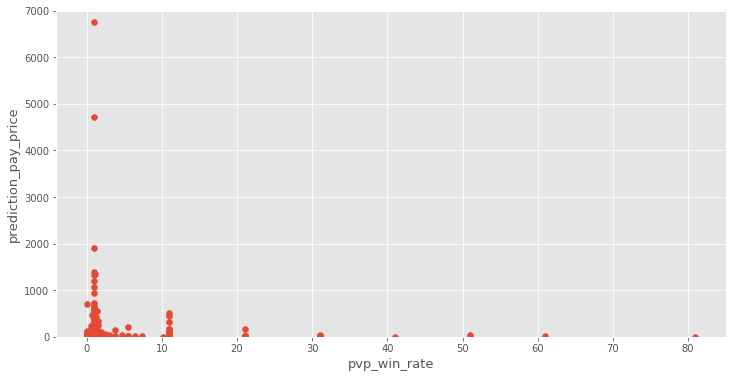

115


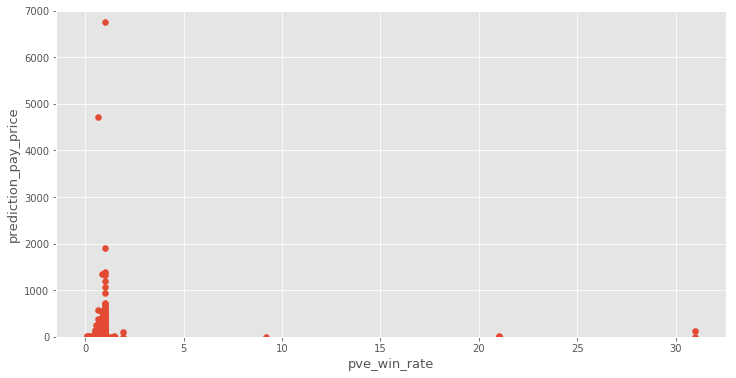

116


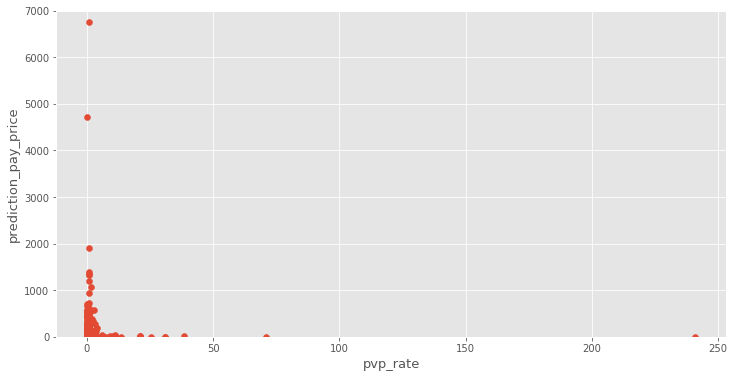

117


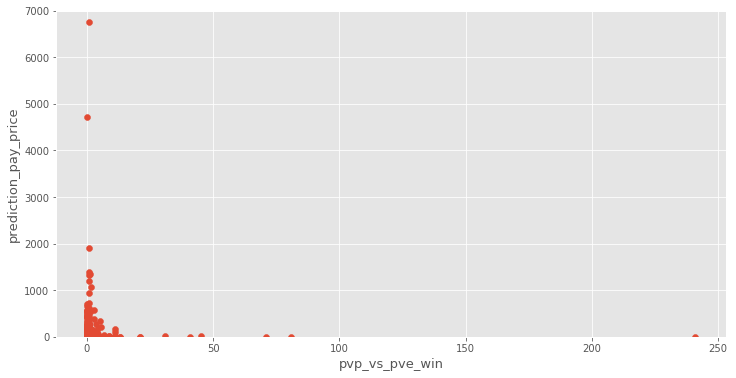

118


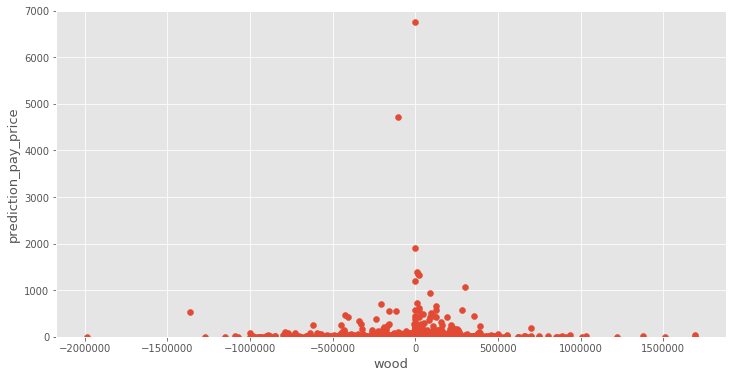

119


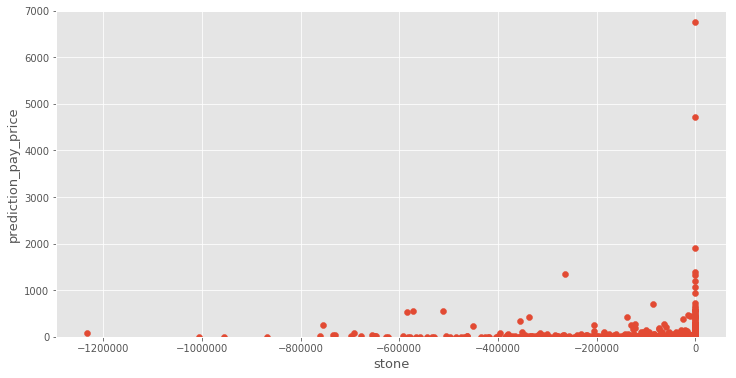

120


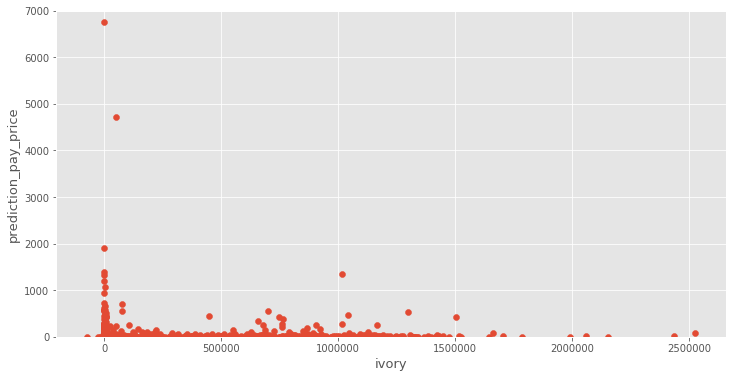

121


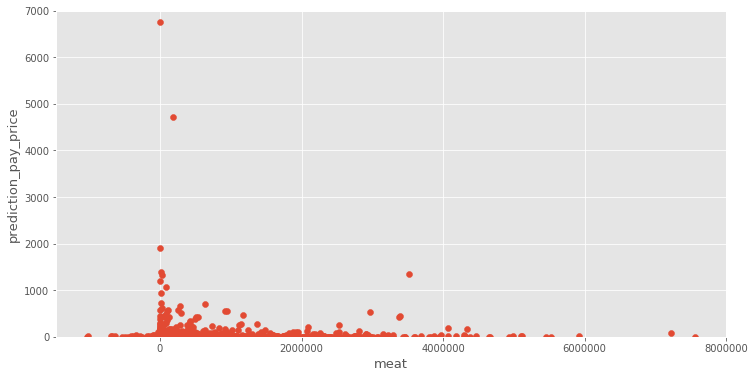

122


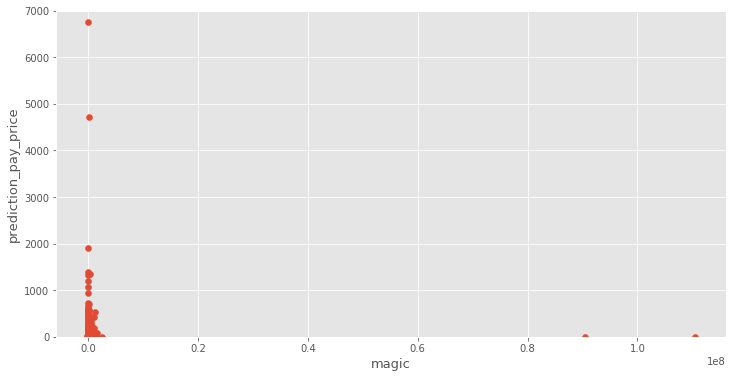

123


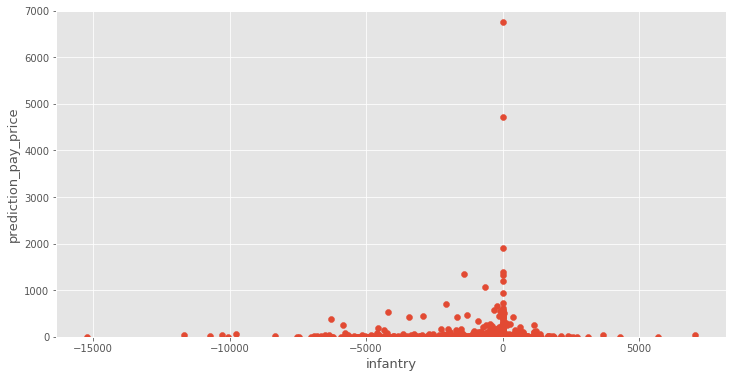

124


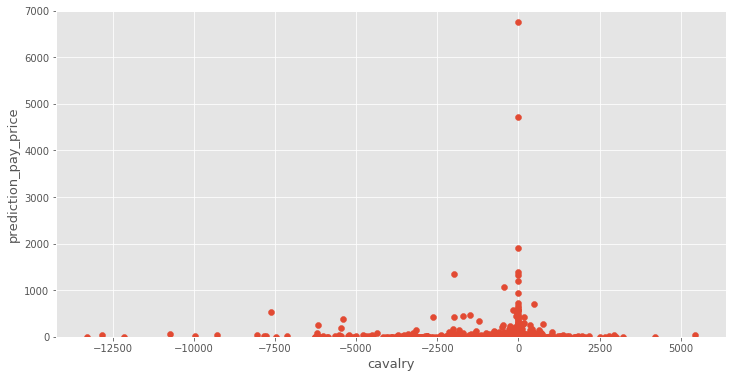

125


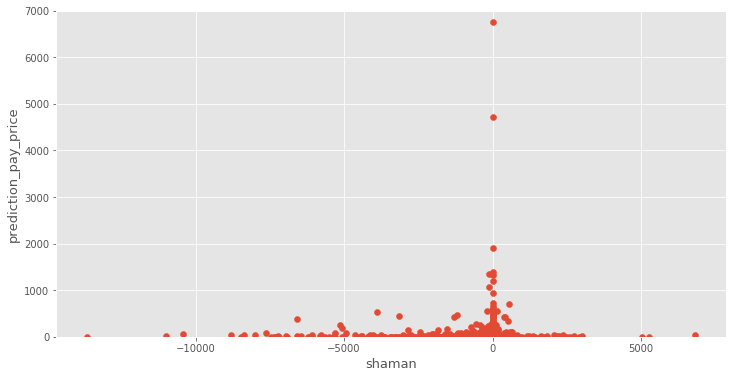

126


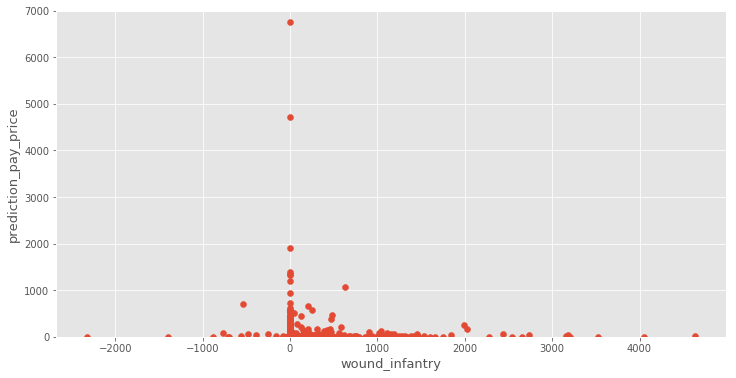

127


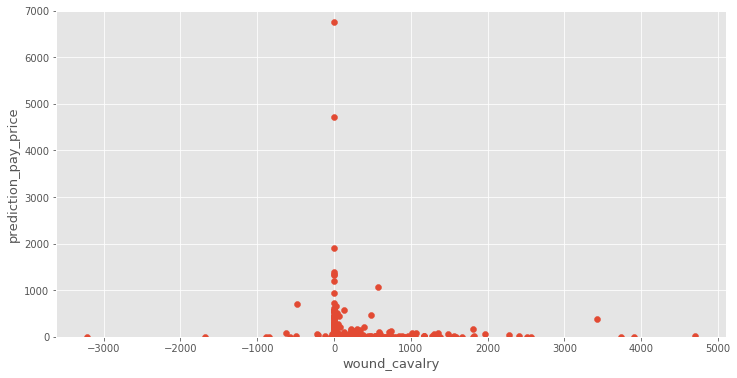

128


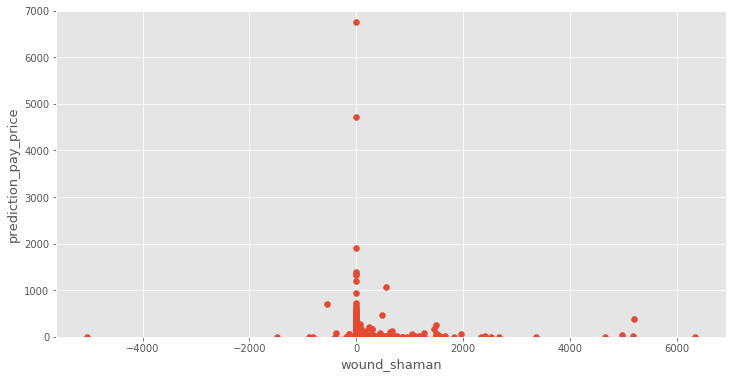

129


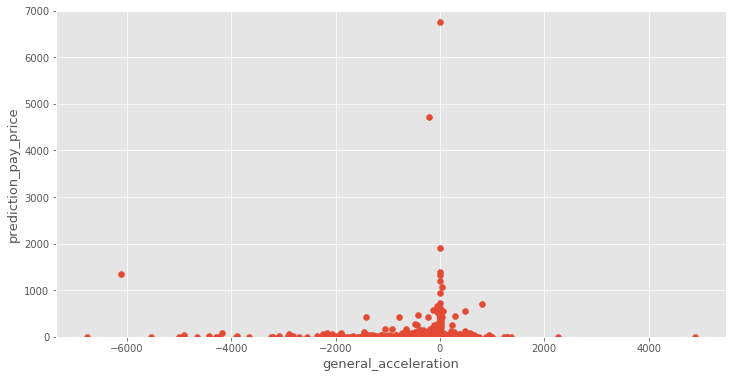

130


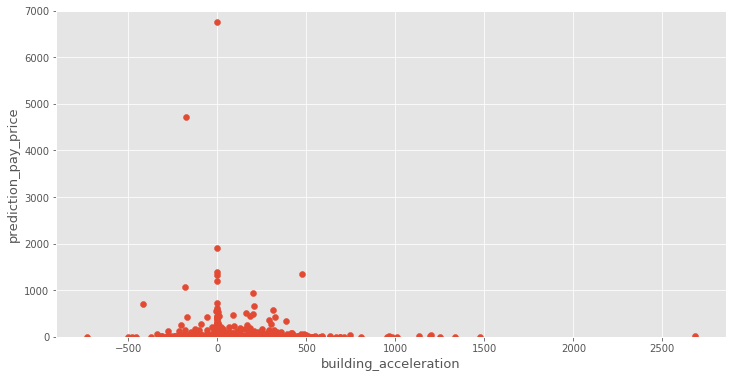

131


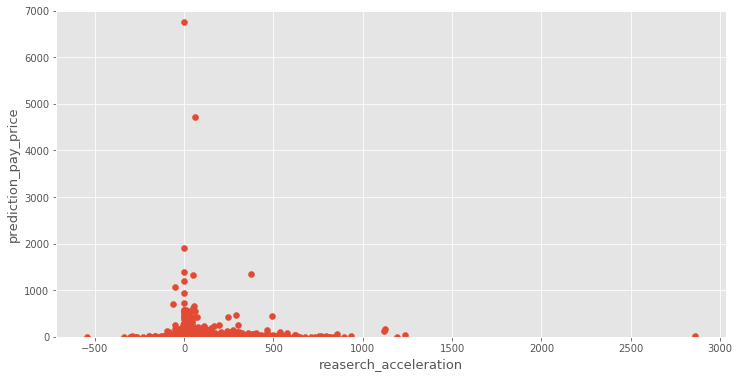

132


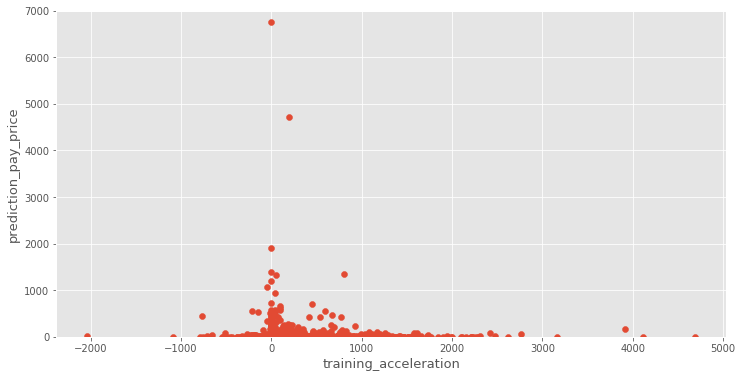

133


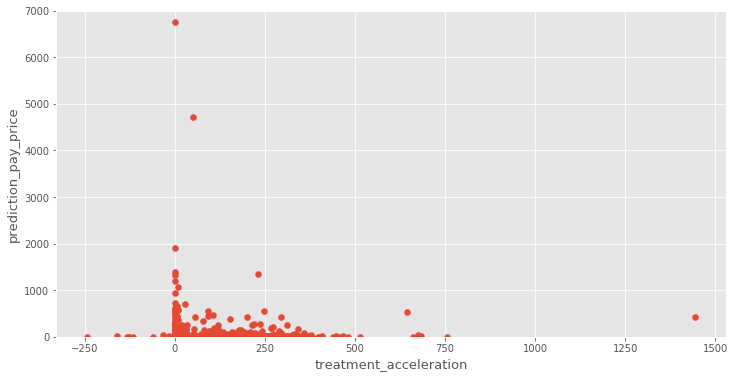

134


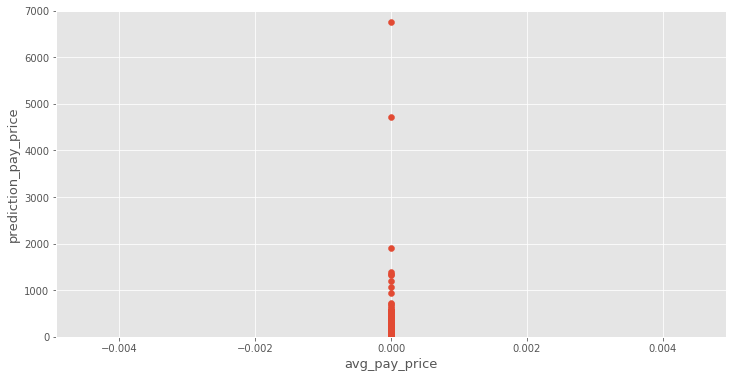

135


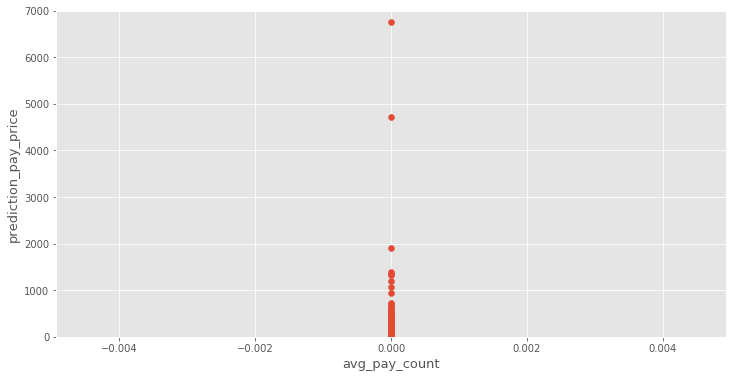

136


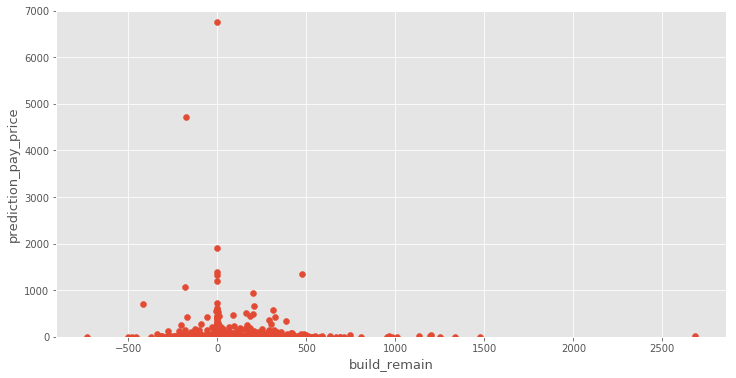

137


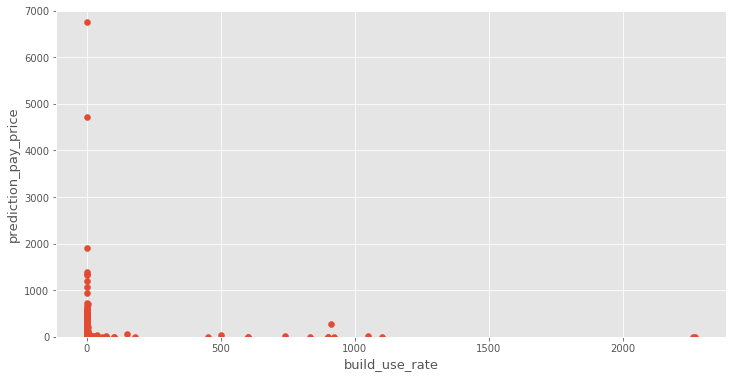

138


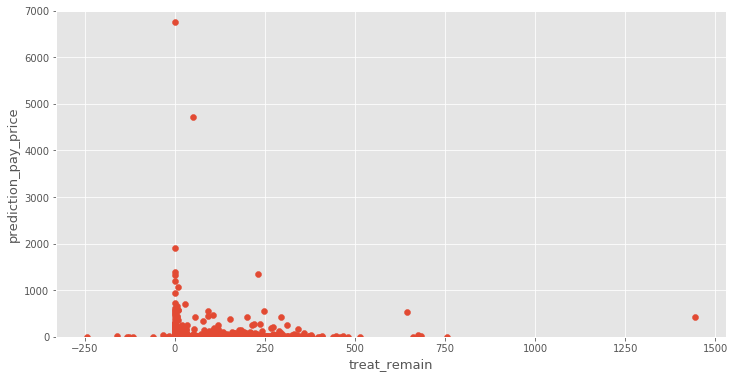

139


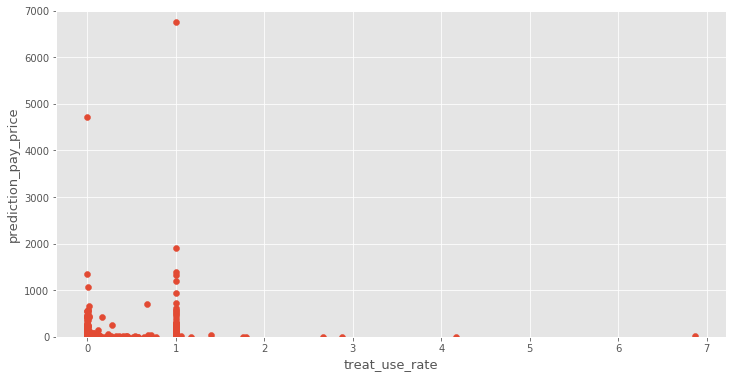

140


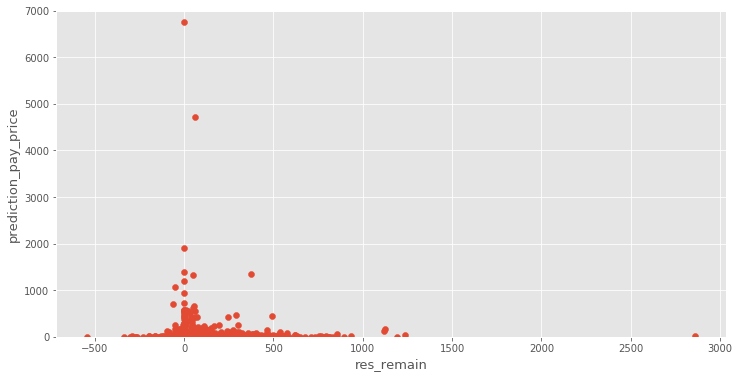

141


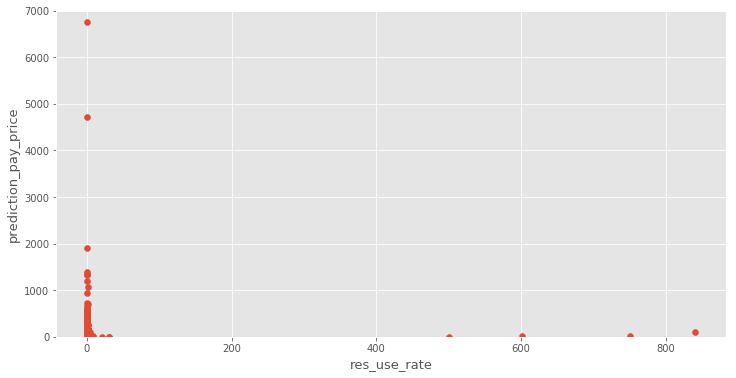

142


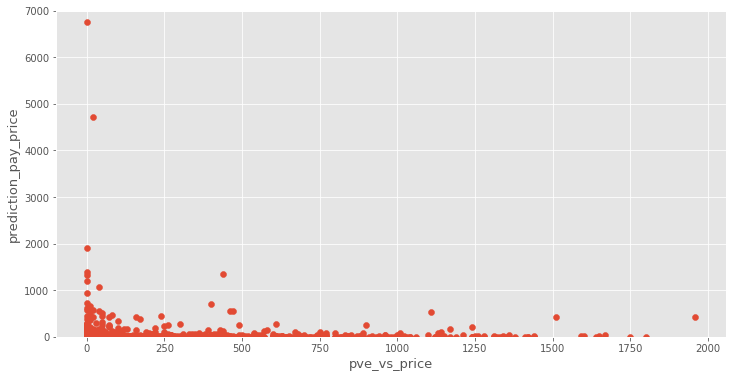

143


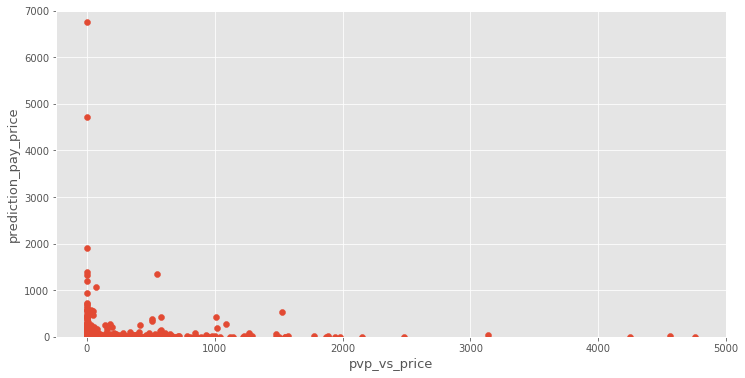

144


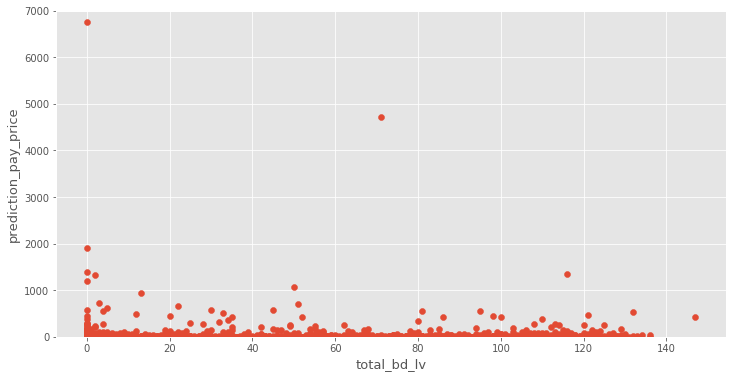

145


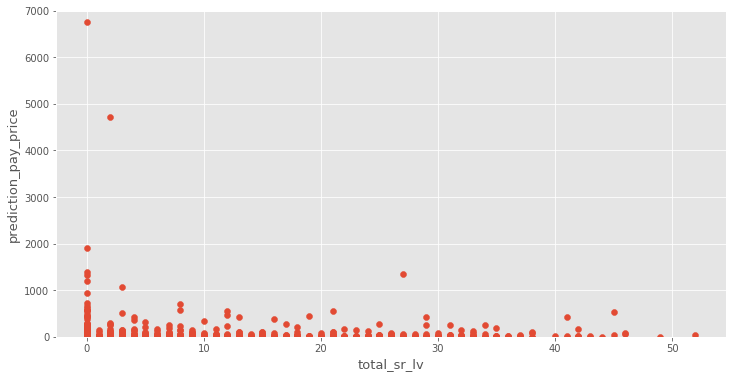

146


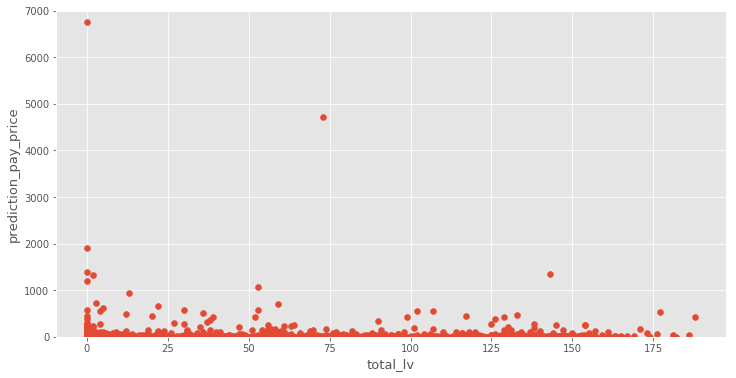

147


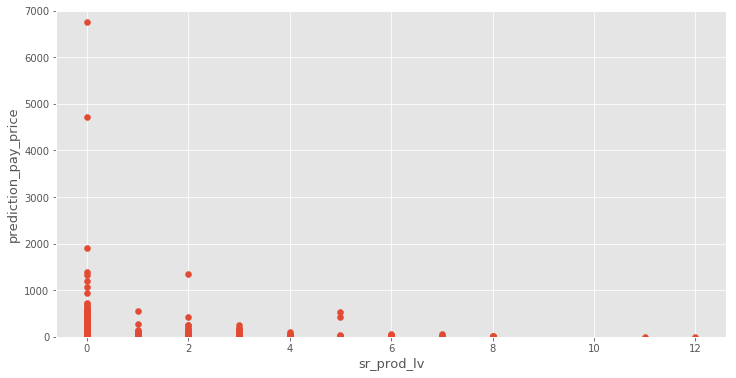

148


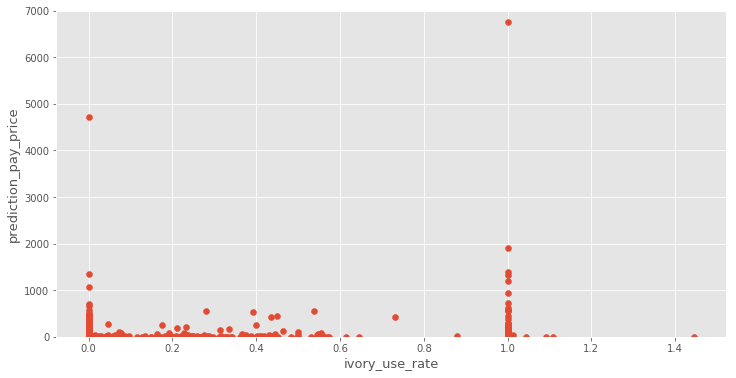

149


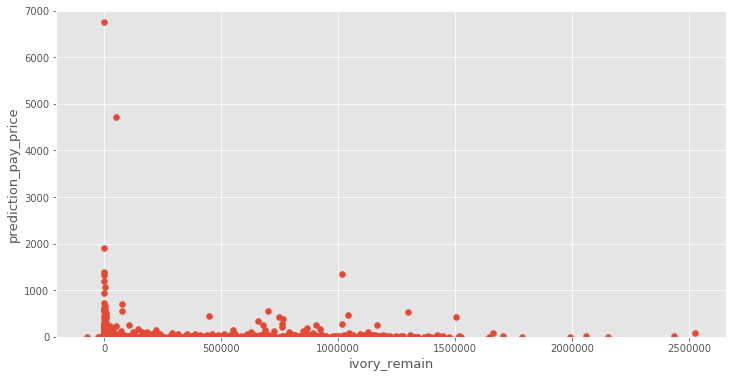

In [17]:
cols = [ x for x in lable3.columns if x not in ['prediction_pay_price']]
i=0
for col in cols:
    print i
    plt.figure(figsize=(12,6))
    plt.scatter(x=lable3[col], y=lable3.prediction_pay_price)
    plt.xlabel(col, fontsize=13)
    plt.ylabel("prediction_pay_price", fontsize=13)
    plt.ylim(0,7000)
    plt.show()
    i+=1

In [37]:
train_cols =[x for x in lable3.columns if x not in lable3.columns[cols_buyao]]
lable3_train = lable3[train_cols]
lable3_train.shape

(1457, 77)

In [94]:
def ontransform(X):
    X['prediction_pay_price_2'] = X['prediction_pay_price']
    del X['prediction_pay_price']
    X.rename(columns={'prediction_pay_price_2':'prediction_pay_price'}, inplace = True)
    x, y = X.iloc[:, 0:len(X.columns)-1], X.iloc[:,len(X.columns)-1:]
        
#     pca = PCA(n_components=39)
#     x=pca.fit_transform(x)
        
#     x = StandardScaler().fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.5)
        
    y_train = y_train['prediction_pay_price'].values
    y_test = y_test['prediction_pay_price'].values

    print('Start training...')
        # train
    gbm = lgb.LGBMRegressor(objective='regression',
                            num_leaves=63,
                            learning_rate=0.01,
                            n_estimators=50)
    gbm.fit(x_train, y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='l1',
            early_stopping_rounds=100,
            verbose= 100
            )


    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    #feature importances
    print('Feature importances:', list(gbm.feature_importances_))
    return list(gbm.feature_importances_)
    

In [106]:
impo_list = ontransform(lable3)
len(impo_list),lable3_train.shape

Start training...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 56.2207
('The rmse of prediction is:', 209.07647544224275)
('Feature importances:', [5, 1, 1, 3, 0, 2, 0, 0, 0, 2, 3, 0, 2, 1, 2, 0, 0, 1, 0, 3, 1, 0, 1, 3, 0, 0, 1, 1, 3, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 6, 0, 0, 0])


(108, (1457, 77))

In [108]:
impo_list = ontransform(lable3)

Start training...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[13]	valid_0's l1: 56.1742
('The rmse of prediction is:', 208.61937024487383)
('Feature importances:', [17, 6, 2, 0, 8, 0, 12, 9, 5, 0, 10, 8, 3, 2, 7, 10, 1, 13, 9, 1, 1, 1, 19, 21, 7, 23, 12, 13, 12, 12, 8, 0, 15, 3, 5, 3, 1, 2, 0, 1, 1, 1, 1, 1, 16, 1, 9, 6, 3, 3, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 10, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 17, 1, 2, 9, 1, 17, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 25, 12, 11, 18, 3, 7, 23, 24, 12, 8, 6, 1, 0, 3, 9, 25, 6, 20, 5, 0, 0, 0, 2, 0, 7, 0, 20, 0, 0, 8, 27, 2, 4, 21, 0])


In [109]:
cols_ = []
for i in range(len(impo_list)):
    if impo_list[i] != 0:
        cols_.append(lable3.columns[i])
cols_.append('prediction_pay_price')
lable3_train_2 = lable3[cols_]
len(impo_list),lable3_train_2.shape

(149, (4549, 88))

In [110]:
impo_list = ontransform(lable3_train_2)

Start training...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[13]	valid_0's l1: 56.1742
('The rmse of prediction is:', 208.61937024487383)
('Feature importances:', [17, 6, 2, 8, 12, 9, 5, 10, 8, 3, 2, 7, 10, 1, 13, 9, 1, 1, 1, 19, 21, 7, 23, 12, 13, 12, 12, 8, 15, 3, 5, 3, 1, 2, 1, 1, 1, 1, 1, 16, 1, 9, 6, 3, 3, 8, 4, 2, 1, 1, 10, 5, 1, 17, 1, 2, 9, 1, 17, 75, 19, 25, 12, 11, 18, 3, 7, 23, 24, 12, 8, 6, 1, 3, 9, 25, 6, 20, 5, 2, 7, 20, 8, 27, 2, 4, 21])


In [112]:
class add_haoduo_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):
        for i in range(len(X.columns)):
            for j in range(i+1,len(X.columns)):
                X[X.columns[i]+'+'+X.columns[j]] = X[X.columns[i]] + X[X.columns[j]]
        return X

In [ ]:
pipe = Pipeline([
    ('add_haoduo_feature', add_haoduo_feature(additional=2))
    ])

lable3_train_3 = pipe.fit_transform(lable3_train_2)
lable3_train_3.shape